# KEN3450, Data Analysis 2020 

**Kaggle Competition 2020**<br>

In [439]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import SelectKBest

#import your classifiers here

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [440]:
#Pandas options
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.set_option.html

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Diagnosing the Maastricht Flu 

You are given the early data for an outbreak of a dangerous virus originating from a group of primates being kept in a Maastricht biomedical research lab in the basement of Henri-Paul Spaaklaan building, this virus is dubbed the "Maastricht Flu".

You have the medical records of $n$ number of patients in `flu_train.csv`. There are two general types of patients in the data, flu patients and healthy (this is recorded in the column labeled `flu`, a 0 indicates the absences of the virus and a 1 indicates presence). Notice that the dataset is unbalanced and you can expect a similar imbalance in the testing set.

**Your task:** build a model to predict if a given patient has the flu. Your goal is to catch as many flu patients as possible without misdiagnosing too many healthy patients.

**The deliverable:** submit your final solution via Kaggle competition using the `flu_test.csv` data.

Maastricht Gemeente will use your model to diagnose sets of future patients (held by us). You can expect that there will be an increase in the number of flu patients in any groups of patients in the future.

Here are some benchmarks for comparison and for expectation management. Notice that because the dataset is unbalanced, we expect that there is going to be a large difference in the accuracy for each class, thus `accuracy` is a metric that might be misleading in this case (see also below). That's why the baselines below are based on the expected accuracy **per class** and also they give you an estimate for the AUROC on all patients in the testing data. This is the score you see in the Kaggle submission as well.

**Baseline Model:** 
- ~50% expected accuracy on healthy patients in training data
- ~50% expected accuracy on flu patients in training data
- ~50% expected accuracy on healthy patients in testing data (future data, no info on the labels)
- ~50% expected accuracy on flu patients in testing data (future data, no info on the labels)
- ~50% expected AUROC on all patients in testing data (future data, no info on the labels)

**Reasonable Model:** 
- ~70% expected accuracy on healthy patients in training data
- ~55% expected accuracy on flu patients, in training data
- ~70% expected accuracy on healthy patients in testing data (future data, no info on the labels, to be checked upon your submission)
- ~57% expected accuracy on flu patients, in testing data (future data, no info on the labels, to be checked upon your submission)
- ~65% expected AUROC on all patients, in testing data (future data, no info on the labels, to be checked from Kaggle)

**Grading:**
Your grade will be based on:
1. your model's ability to out-perform the benchmarks (they are kind of low, so we won't care much about this)
2. your ability to carefully and thoroughly follow the data analysis pipeline
3. the extend to which all choices are reasonable and defensible by methods you have learned in this class

## Step 1: Read the data, clean and explore the data

There are a large number of missing values in the data. Nearly all predictors have some degree of missingness. Not all missingness are alike: NaN in the `'pregnancy'` column is meaningful and informative, as patients with NaN's in the pregnancy column are males, where as NaN's in other predictors may appear randomly. 


**What do you do?:** We make no attempt to interpret the predictors and we make no attempt to model the missing values in the data in any meaningful way. We replace all missing values with 0.

However, it would be more complete to look at the data and allow the data to inform your decision on how to address missingness. For columns where NaN values are informative, you might want to treat NaN as a distinct value; You might want to drop predictors with too many missing values and impute the ones with few missing values using a model. There are many acceptable strategies here, as long as the appropriateness of the method in the context of the task and the data is discussed.

In [441]:
#Train
df = pd.read_csv('data/flu_train.csv')
df = df[~np.isnan(df['flu'])]
df.head()

ID  Gender  Age  Race1     Education MaritalStatus     HHIncome  \
0  51624    male   34  White   High School       Married  25000-34999   
1  51630  female   49  White  Some College   LivePartner  35000-44999   
2  51638    male    9  White           NaN           NaN  75000-99999   
3  51646    male    8  White           NaN           NaN  55000-64999   
4  51647  female   45  White  College Grad       Married  75000-99999   

   HHIncomeMid  Poverty  HomeRooms HomeOwn        Work  Weight  Length  \
0      30000.0     1.36        6.0     Own  NotWorking    87.4     NaN   
1      40000.0     1.91        5.0    Rent  NotWorking    86.7     NaN   
2      87500.0     1.84        6.0    Rent         NaN    29.8     NaN   
3      60000.0     2.33        7.0     Own         NaN    35.2     NaN   
4      87500.0     5.00        6.0     Own     Working    75.7     NaN   

   HeadCirc  Height    BMI BMICatUnder20yrs       BMI_WHO  Pulse  BPSysAve  \
0       NaN   164.7  32.22              NaN     30.0_plus   70.0     113.0   
1       NaN   168.4  30.57              NaN     30.0_plus   86.0     112.0   
2       NaN   133.1  16.82              NaN     12.0_18.5   82.0      86.0   
3       NaN   130.6  20.64              NaN  18.5_to_24.9   72.0     107.0   
4       NaN   166.7  27.24              NaN  25.0_to_29.9   62.0     118.0   

   BPDiaAve  BPSys1  BPDia1  BPSys2  BPDia2  BPSys3  BPDia3  Testosterone  \
0      85.0   114.0    88.0   114.0    88.0   112.0    82.0           NaN   
1      75.0   118.0    82.0   108.0    74.0   116.0    76.0           NaN   
2      47.0    84.0    50.0    84.0    50.0    88.0    44.0           NaN   
3      37.0   114.0    46.0   108.0    36.0   106.0    38.0           NaN   
4      64.0   106.0    62.0   118.0    68.0   118.0    60.0           NaN   

   DirectChol  TotChol  UrineVol1  UrineFlow1  UrineVol2  UrineFlow2 Diabetes  \
0        1.29     3.49      352.0         NaN        NaN         NaN       No   
1        1.16     6.70       77.0       0.094        NaN         NaN       No   
2        1.34     4.86      123.0       1.538        NaN         NaN       No   
3        1.55     4.09      238.0       1.322        NaN         NaN       No   
4        2.12     5.82      106.0       1.116        NaN         NaN       No   

   DiabetesAge HealthGen  DaysMentHlthBad LittleInterest Depressed  \
0          NaN      Good             15.0           Most   Several   
1          NaN      Good             10.0        Several   Several   
2          NaN       NaN              NaN            NaN       NaN   
3          NaN       NaN              NaN            NaN       NaN   
4          NaN     Vgood              3.0           None      None   

   nPregnancies  nBabies  Age1stBaby  SleepHrsNight SleepTrouble PhysActive  \
0           NaN      NaN         NaN            4.0          Yes         No   
1           2.0      2.0        27.0            8.0          Yes         No   
2           NaN      NaN         NaN            NaN          NaN        NaN   
3           NaN      NaN         NaN            NaN          NaN        NaN   
4           1.0      NaN         NaN            8.0           No        Yes   

   PhysActiveDays TVHrsDay CompHrsDay  TVHrsDayChild  CompHrsDayChild  \
0             NaN      NaN        NaN            NaN              NaN   
1             NaN      NaN        NaN            NaN              NaN   
2             NaN      NaN        NaN            5.0              0.0   
3             NaN      NaN        NaN            1.0              6.0   
4             5.0      NaN        NaN            NaN              NaN   

  Alcohol12PlusYr  AlcoholDay  AlcoholYear SmokeNow Smoke100   Smoke100n  \
0             Yes         NaN          0.0       No      Yes      Smoker   
1             Yes         2.0         20.0      Yes      Yes      Smoker   
2             NaN         NaN          NaN      NaN      NaN         NaN   
3             NaN         NaN          NaN      NaN      NaN    

In [442]:
#Test
df_test = pd.read_csv('data/flu_test.csv')
df_test.head()

ID  Gender  Age  Race1     Education MaritalStatus     HHIncome  \
0  51625    male    4  Other           NaN           NaN  20000-24999   
1  51678    male   60  White   High School       Married  15000-19999   
2  51694    male   38  White  Some College       Married  20000-24999   
3  51695    male    8  White           NaN           NaN  65000-74999   
4  51711  female   59  Other     8th Grade       Widowed  20000-24999   

   HHIncomeMid  Poverty  HomeRooms HomeOwn        Work  Weight  Length  \
0      22500.0     1.07        9.0     Own         NaN    17.0     NaN   
1      17500.0     1.03        5.0     Own     Working    74.6     NaN   
2      22500.0     1.15        6.0     Own     Working   117.3     NaN   
3      70000.0     3.55        5.0     Own         NaN    40.1     NaN   
4      22500.0     1.37        4.0    Rent  NotWorking    54.3     NaN   

   HeadCirc  Height    BMI BMICatUnder20yrs       BMI_WHO  Pulse  BPSysAve  \
0       NaN   105.4  15.30              NaN     12.0_18.5    NaN       NaN   
1       NaN   169.9  25.84              NaN  25.0_to_29.9   84.0     152.0   
2       NaN   180.9  35.84              NaN     30.0_plus   60.0     147.0   
3       NaN   128.4  24.32              NaN  18.5_to_24.9   76.0      93.0   
4       NaN   145.1  25.79              NaN  25.0_to_29.9   84.0     150.0   

   BPDiaAve  BPSys1  BPDia1  BPSys2  BPDia2  BPSys3  BPDia3  Testosterone  \
0       NaN     NaN     NaN     NaN     NaN     NaN     NaN           NaN   
1     100.0   154.0    98.0   150.0    98.0   154.0   102.0           NaN   
2      81.0   160.0    84.0   150.0    80.0   144.0    82.0           NaN   
3      54.0    86.0    52.0    94.0    56.0    92.0    52.0           NaN   
4       0.0   144.0     0.0   150.0     0.0   150.0     0.0           NaN   

   DirectChol  TotChol  UrineVol1  UrineFlow1  UrineVol2  UrineFlow2 Diabetes  \
0         NaN      NaN        NaN         NaN        NaN         NaN       No   
1        1.34     6.39      238.0         NaN        NaN         NaN       No   
2        0.93     4.68       73.0       0.468        NaN         NaN       No   
3        1.53     4.14      124.0       0.366        NaN         NaN       No   
4        1.06     4.16       42.0       0.389        NaN         NaN      Yes   

   DiabetesAge HealthGen  DaysMentHlthBad LittleInterest Depressed  \
0          NaN       NaN              NaN            NaN       NaN   
1          NaN     Vgood              0.0           None      None   
2          NaN      Poor              4.0        Several      None   
3          NaN       NaN              NaN            NaN       NaN   
4         51.0       NaN              NaN            NaN       NaN   

   nPregnancies  nBabies  Age1stBaby  SleepHrsNight SleepTrouble PhysActive  \
0           NaN      NaN         NaN            NaN          NaN        NaN   
1           NaN      NaN         NaN            6.0          Yes         No   
2           NaN      NaN         NaN            5.0           No         No   
3           NaN      NaN         NaN            NaN          NaN        NaN   
4           NaN      NaN         NaN            5.0          Yes         No   

   PhysActiveDays TVHrsDay CompHrsDay  TVHrsDayChild  CompHrsDayChild  \
0             NaN      NaN        NaN            4.0              1.0   
1             NaN      NaN        NaN            NaN              NaN   
2             NaN      NaN        NaN            NaN              NaN   
3             NaN      NaN        NaN            1.0              0.0   
4             NaN      NaN        NaN            NaN              NaN   

  Alcohol12PlusYr  AlcoholDay  AlcoholYear SmokeNow Smoke100   Smoke100n  \
0             NaN         NaN          NaN      NaN      NaN         NaN   
1             Yes         6.0         36.0       No      Yes      Smoker   
2              No         NaN          0.0      NaN       No  Non-Smoker   
3             NaN         NaN          NaN      NaN      NaN    

In [443]:
#What's up in each set

x = df.values[:, :-1]
y = df.values[:, -1]

x_test = df_test.values[:, :-1]

print('x train shape:', x.shape)
print('x test shape:', x_test.shape)
print('train class 0: {}, train class 1: {}'.format(len(y[y==0]), len(y[y==1])))

x train shape: (5246, 71)
x test shape: (1533, 70)
train class 0: 4936, train class 1: 310


---
### Data Exploration ###

Initial expection for the data's missing values, quartiles, min/max and standard deviation.

In [444]:
df.describe()

ID          Age    HHIncomeMid      Poverty    HomeRooms  \
count   5246.000000  5246.000000    4798.000000  4843.000000  5210.000000   
mean   61707.937286    35.078155   54079.824927     2.614229     6.147025   
std     5876.826538    23.032443   32956.594998     1.672579     2.223687   
min    51624.000000     0.000000    2500.000000     0.000000     1.000000   
25%    56623.250000    15.000000   22500.000000     1.110000     5.000000   
50%    61669.500000    33.000000   50000.000000     2.320000     6.000000   
75%    66841.250000    53.000000   87500.000000     4.340000     7.000000   
max    71915.000000    80.000000  100000.000000     5.000000    13.000000   

            Weight      Length   HeadCirc       Height          BMI  \
count  5206.000000  356.000000  61.000000  5014.000000  5010.000000   
mean     68.701921   84.363483  41.101639   160.341424    26.371601   
std      29.774856   13.827255   2.381561    21.043275     7.464134   
min       2.800000   47.100000  34.200000    83.600000    12.880000   
25%      53.000000   73.950000  39.600000   155.400000    21.200000   
50%      70.600000   86.150000  41.200000   165.000000    25.700000   
75%      87.300000   95.325000  42.900000   173.600000    30.500000   
max     223.000000  112.200000  45.400000   200.400000    80.600000   

             Pulse     BPSysAve     BPDiaAve       BPSys1       BPDia1  \
count  4376.000000  4369.000000  4369.000000  4213.000000  4213.000000   
mean     73.546618   117.683680    66.554131   118.668882    67.511987   
std      12.230290    17.390216    14.862799    17.756124    14.133913   
min      40.000000    76.000000     0.000000    76.000000     0.000000   
25%      64.000000   106.000000    60.000000   106.000000    60.000000   
50%      72.000000   115.000000    68.000000   116.000000    68.000000   
75%      82.000000   127.000000    76.000000   128.000000    76.000000   
max     134.000000   226.000000   116.000000   232.000000   118.000000   

            BPSys2       BPDia2       BPSys3       BPDia3  Testosterone  \
count  4263.000000  4263.000000  4261.000000  4261.000000   2008.000000   
mean    118.036125    66.709360   117.507627    66.311195    190.980538   
std      17.666221    14.919705    17.343120    15.611776    225.730181   
min      78.000000     0.000000    76.000000     0.000000      0.250000   
25%     106.000000    60.000000   106.000000    60.000000     16.905000   
50%     116.000000    68.000000   116.000000    68.000000     39.090000   
75%     126.000000    76.000000   126.000000    76.000000    351.765000   
max     226.000000   118.000000   226.000000   116.000000   1795.600000   

        DirectChol      TotChol    UrineVol1   UrineFlow1   UrineVol2  \
count  4337.000000  4337.000000  4637.000000  4300.000000  763.000000   
mean      1.357699     4.835764   117.415570     0.957834  119.213630   
std       0.387915     1.069526    90.204645     0.958016   90.269022   
min       0.390000     1.530000     0.000000     0.000000    0.000000   
25%       1.090000     4.090000    49.000000     0.395000   50.000000   
50%       1.290000     4.730000    92.000000     0.678500   92.000000   
75%       1.580000     5.510000   162.000000     1.187000  170.500000   
max       4.030000    13.650000   488.000000    17.167000  409.000000   

       UrineFlow2  DiabetesAge  DaysMentHlthBad  nPregnancies      nBabies  \
count  763.000000   330.000000      3778.000000   1283.000000  1182.000000   
mean     1.166626    49.339394         3.946268      3.060016     2.529611   
std      1.113726    15.788109         7.681957      1.738878     1.369334   
min      0.000000     1.000000         0.000000      1.000000     0.000000   
25%      0.474000    41.000000         0.000000      2.000000     2.000000   
50%      0.778000    50.000000         0.000000      3.000000     2.000000   
75%      1.570000    60.000000         4.000000      4.000000     3.000000   
max     13.692000    80.000000        30.000000     13.000

As it can be seen, many features contain missing values. However, in some of these columns the missing value has meaning. For example a missing value in SmokeAge means that the individual has never smoked.

In [445]:
df.dtypes

ID                    int64
Gender               object
Age                   int64
Race1                object
Education            object
MaritalStatus        object
HHIncome             object
HHIncomeMid         float64
Poverty             float64
HomeRooms           float64
HomeOwn              object
Work                 object
Weight              float64
Length              float64
HeadCirc            float64
Height              float64
BMI                 float64
BMICatUnder20yrs     object
BMI_WHO              object
Pulse               float64
BPSysAve            float64
BPDiaAve            float64
BPSys1              float64
BPDia1              float64
BPSys2              float64
BPDia2              float64
BPSys3              float64
BPDia3              float64
Testosterone        float64
DirectChol          float64
TotChol             float64
UrineVol1           float64
UrineFlow1          float64
UrineVol2           float64
UrineFlow2          float64
Diabetes            

### Analysing different features ###

**Gender**

In [446]:
df['Gender'].isna().sum()

0

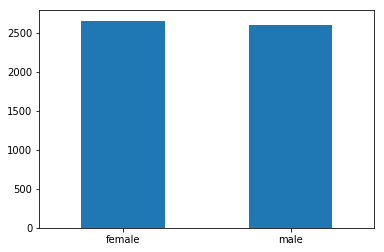

In [447]:
df['Gender'].value_counts().plot.bar(rot=0)
plt.show()

There are no null values in this column. As it can be seen, there the two genders present in the dataset and they are quite balanced.

**Age**

In [448]:
df['Age'].isna().sum()

0

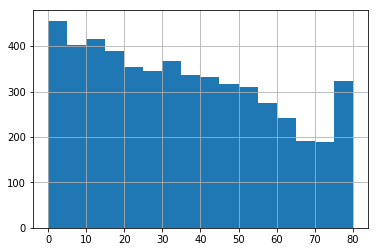

In [449]:
df['Age'].hist(bins=16)
plt.show()

No missing values. It can be observed that the age is not normally distributed in the dataset.

**Race**

In [450]:
df['Race1'].isna().sum()

0

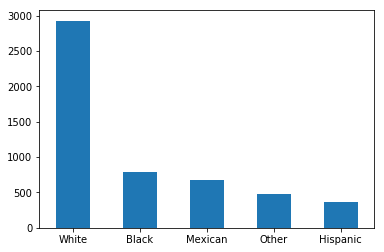

In [451]:
df['Race1'].value_counts().plot.bar(rot=0)
plt.show()

No missing values. As the classes are quite unbalanced where `White` is in the majority of instances it is decided to aggregate the other classes together. This means that the cleaned data just contains whether any given individual is white or not.

**Education**

In [452]:
df['Education'].isna().sum()

1672

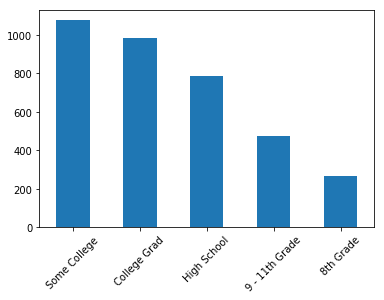

In [453]:
df['Education'].value_counts().plot.bar(rot=45)
plt.show()

In which age groups is the data missing?

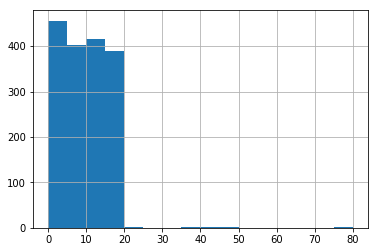

In [454]:
df.loc[df['Education'].isna()]['Age'].hist(bins=16)
plt.show()

In [455]:
dummies = pd.get_dummies(df['Education'])
pd.concat([dummies, df['Age']], axis=1).corr()['Age']

8th Grade         0.188678
9 - 11th Grade    0.172576
College Grad      0.242017
High School       0.226814
Some College      0.222016
Age               1.000000
Name: Age, dtype: float64

1672 instance don't have a value in the 'Education' feature. It looks like this features tells at what point a given individual has stopped his/her education. This means that the dataset has missing values for young people that are still at school or at university. This is changed into the education level that has been currently achieved by estimating in which education category each individual is using the age.
The remaining few people which are older than 35 where it can be assumed that they have finished their education have the values filled in by looking at what is the most prominent category per age group. By simple intuition age is maybe not very telling at what point education was finished when they were younger. However it can be assumed that the data was collected in the same time period which could be even of a few years. And depending on different time periods the level of education that people got is different. For example, in the 60s going to university was much less likely than it is today.

**Marital Status**

In [456]:
df['MaritalStatus'].isna().sum()

1666

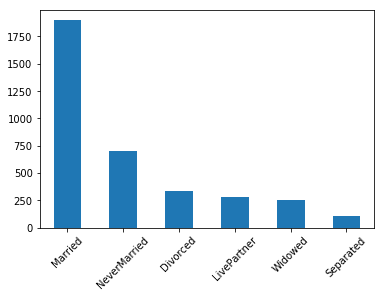

In [457]:
df['MaritalStatus'].value_counts().plot.bar(rot=45)
plt.show()

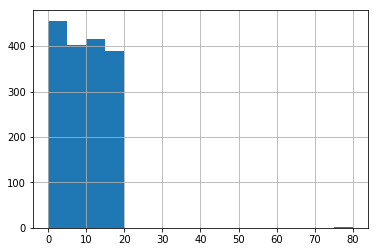

In [458]:
df.loc[df['MaritalStatus'].isna()]['Age'].hist(bins=16)
plt.show()

Similarly to the education example, most missing values arise from young indivuals where it can be assumed that they never married. Instead for the remaining missing values of older people the missing values are filled in depending on the age group.

In [459]:
#df.at[df['MaritalStatus'].isna(), 'MaritalStatus'] = df.loc[(df['Age']>=75) & (df['Age']<85), 'MaritalStatus'].mode()

**HHIncome**

In [460]:
df['HHIncome'].isna().sum()

448

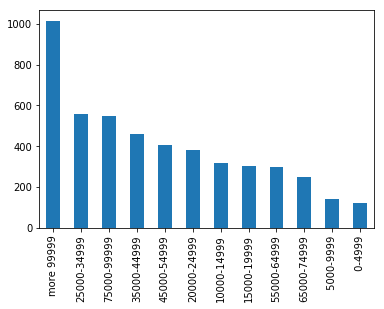

In [461]:
df['HHIncome'].value_counts().plot.bar(rot=90)
plt.show()

This column is not needed as there is already the mid income column for each category. As a result it is dropped.

**HHIncomeMid**

In [462]:
df['HHIncomeMid'].isna().sum()

448

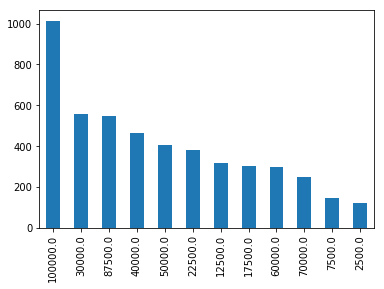

In [463]:
df['HHIncomeMid'].value_counts().plot.bar(rot=90)
plt.show()

The missing values are filled in by taking the most common value.

**Poverty**

In [464]:
df['Poverty'].isna().sum()

403

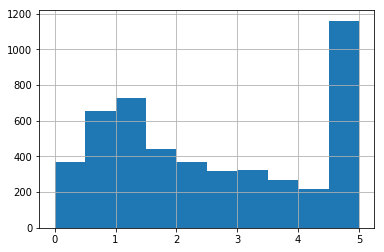

In [465]:
df['Poverty'].hist(bins=10)
plt.show()

The missing values are filled in by taking the mean.

**Home Rooms**

In [466]:
df['HomeRooms'].isna().sum()

36

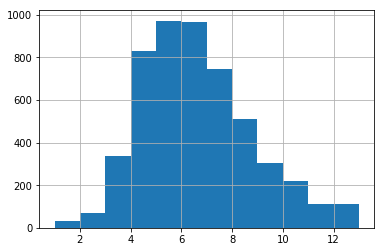

In [467]:
df['HomeRooms'].hist(bins=12)
plt.show()

The data appears to be normally distributed. There are very few data point missing. These are filled in by taking the mean.

**Home Own**

In [468]:
df['HomeOwn'].isna().sum()

33

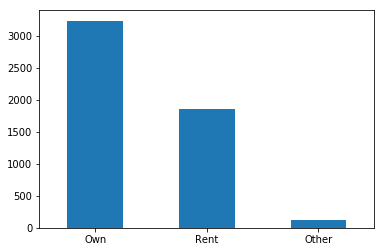

In [469]:
df['HomeOwn'].value_counts().plot.bar(rot=0)
plt.show()

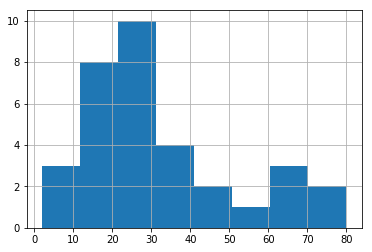

In [470]:
df.loc[df['HomeOwn'].isna()]['Age'].hist(bins=8)
plt.show()

Similarly, there are very few missing values which are filled by using the most common category.

**Work**

In [471]:
df['Work'].isna().sum()

1357

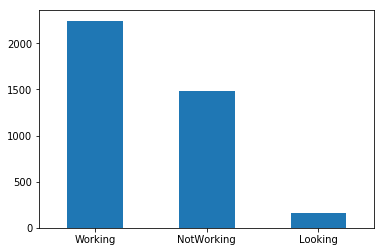

In [472]:
df['Work'].value_counts().plot.bar(rot=0)
plt.show()

In [473]:
len(df[(df['Work'].isna()) & (df['Education'].isna()) & (df['Age']<=20)])

1356

It looks like most of the individuals with missing values in the 'Work' column have not finished their education yet. These are filled with `NotWorking`. Remaining are filled by plugging in the most common category.

**Weight**

In [474]:
df['Weight'].isna().sum()

40

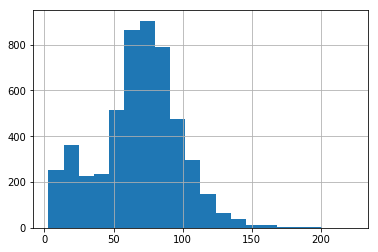

In [475]:
df['Weight'].hist(bins=20)
plt.show()

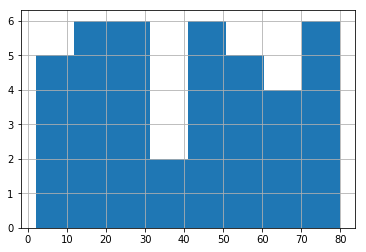

In [476]:
df.loc[df['Weight'].isna()]['Age'].hist(bins=8)
plt.show()

There are few values missing. These are filled in by using the mean of individuals grouped by age group.

**Length**

In [477]:
df['Length'].isna().sum()

4890

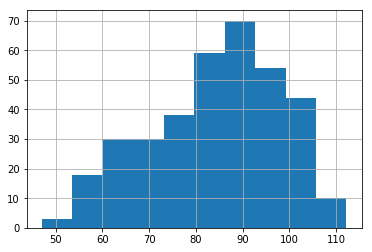

In [478]:
df['Length'].hist()
plt.show()

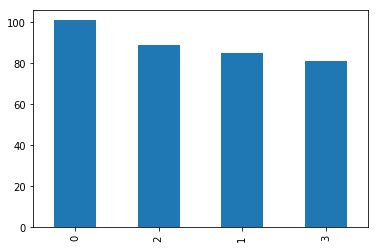

In [479]:
df.loc[df['Length'].notna()]['Age'].value_counts().plot.bar()
plt.show()

This column is only for kids between 0 and 3 years old. This column is merged with the `Height` column as they practically contain the same information.

**Head Circumference**

In [480]:
df['HeadCirc'].notna().sum()

61

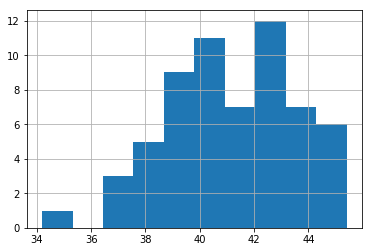

In [481]:
df['HeadCirc'].hist()
plt.show()

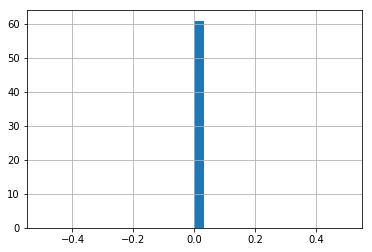

In [482]:
df.loc[df['HeadCirc'].notna()]['Age'].hist(bins=32)
plt.show()

In [483]:
len(df.loc[df['Age']==0])

101

Values are present only for babies. On top of that not even all babies have this value present. Therefore this feature is dropped.

**Height**

In [484]:
df['Height'].isna().sum()

232

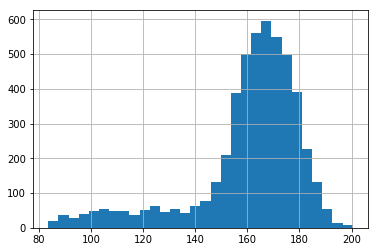

In [485]:
df['Height'].hist(bins=30)
plt.show()

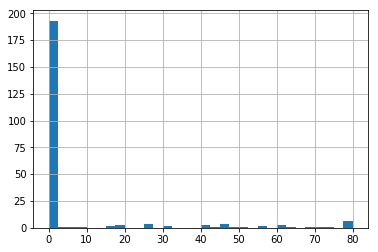

In [486]:
df.loc[df['Height'].isna()]['Age'].hist(bins=32)
plt.show()

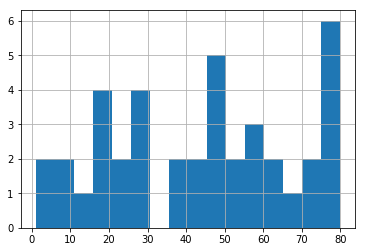

In [487]:
df.loc[(df['Height'].isna()) & (df['Length'].isna())]['Age'].hist(bins=16)
plt.show()

In [488]:
print('Values present in both Height and Length', len(df[(df['Height'].notna()) & (df['Length']).notna()]))
print('Values present in neither Height and Length', len(df[(df['Height'].isna()) & (df['Length']).isna()]))

Values present in both Height and Length 164
Values present in neither Height and Length 40


The data seems to be normally distributed. Most of the missing values are from young children. Where possible the `Length` value is used to fill in the missing values. The remaining missing values could be filled in by taking the mean per age group the individual is part of.

**BMI**

In [489]:
df['BMI'].isna().sum()

236

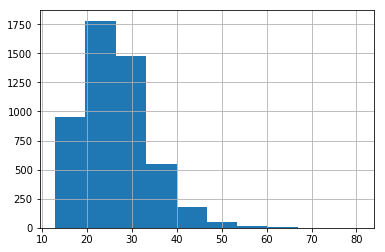

In [490]:
df['BMI'].hist()
plt.show()

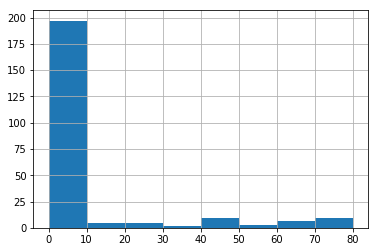

In [491]:
df.loc[df['BMI'].isna()]['Age'].hist(bins=8)
plt.show()

The missing values are calculate using the BMI formula.

**BMI Category Under 20 years**

In [492]:
df.loc[df['Age'] < 20]['BMICatUnder20yrs'].isna().sum()

941

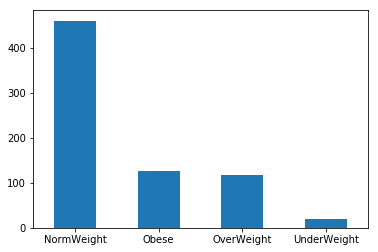

In [493]:
df['BMICatUnder20yrs'].value_counts().plot.bar(rot=0)
plt.show()

Column is dropped as there is a numerical BMI value.

**BMI WHO**

In [494]:
df['BMI_WHO'].isna().sum()

256

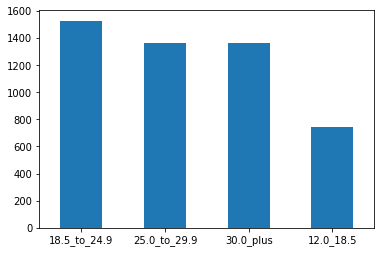

In [495]:
df['BMI_WHO'].value_counts().plot.bar(rot=0)
plt.show()

Column is dropped as there is a numerical BMI value.

**Pulse**

In [496]:
df['Pulse'].isna().sum()

870

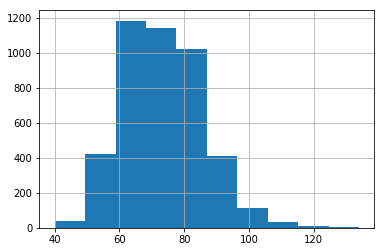

In [497]:
df['Pulse'].hist()
plt.show()

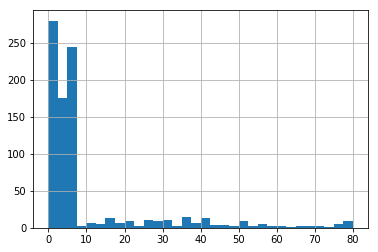

In [498]:
df.loc[df['Pulse'].isna()]['Age'].hist(bins=32)
plt.show()

Most missing values are from kids. 

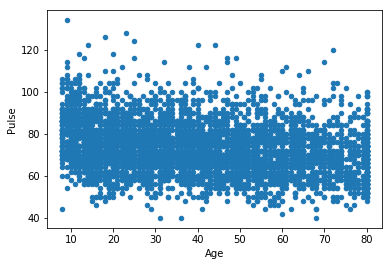

In [499]:
df.plot.scatter('Age', 'Pulse')
plt.show()

Values are filled in by age group. A bin size of 10 is used as seen from the graph, the values over ages do not drastically change.

**BPSysAve**

In [500]:
df['BPSysAve'].isna().sum()

877

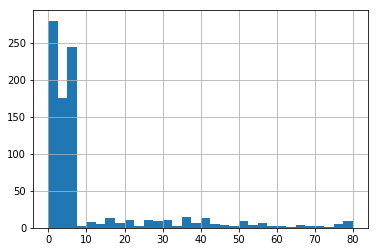

In [501]:
df.loc[df['BPSysAve'].isna()]['Age'].hist(bins=32)
plt.show()

Average value for kids between 0 and 10 years old is filled in. The remaining missing values for people older than 10 years old is filled in with the mean per age group Only average is kept

**BPDiaAve**

In [502]:
df['BPDiaAve'].isna().sum()

877

Only average is kept

**BPSys1**

**BPdDia1**

**BPSys2**

**BPdDia2**

**BPSys3**

**BPdDia3**

**Testosterone**

In [503]:
df['Testosterone'].isna().sum()

3238

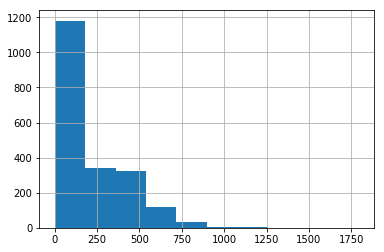

In [504]:
df['Testosterone'].hist()
plt.show()

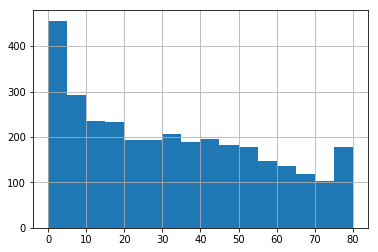

In [505]:
df.loc[df['Testosterone'].isna()]['Age'].hist(bins=16)
plt.show()

Lots of missing values. This attribute is omitted.

**DirectChol**

In [506]:
df['DirectChol'].isna().sum()

909

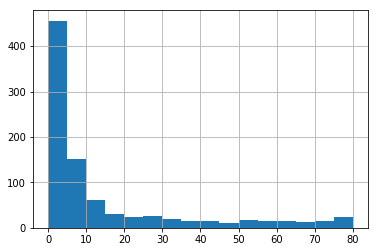

In [507]:
df.loc[df['DirectChol'].isna()]['Age'].hist(bins=16)
plt.show()

In [508]:
df.loc[df['DirectChol'].notna(), 'DirectChol'].head()

0    1.29
1    1.16
2    1.34
3    1.55
4    2.12
Name: DirectChol, dtype: float64

**TotChol**

In [509]:
df['TotChol'].isna().sum()

909

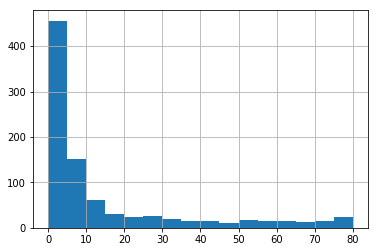

In [510]:
df.loc[df['TotChol'].isna()]['Age'].hist(bins=16)
plt.show()

In [511]:
df.loc[df['TotChol'].notna(), 'TotChol'].head()

0    3.49
1    6.70
2    4.86
3    4.09
4    5.82
Name: TotChol, dtype: float64

**UrineVol1**

**UrineFlow1**

**UrineVol2**

**UrineFlow2**

**Diabetes**

In [512]:
df['Diabetes'].isna().sum()

103

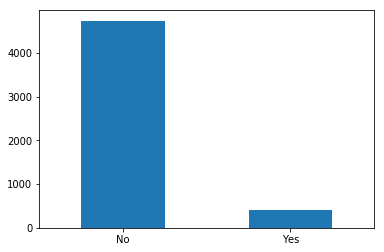

In [513]:
df['Diabetes'].value_counts().plot.bar(rot=0)
plt.show()

In [514]:
df.loc[df['Age'] < 1]['Diabetes'].isna().sum()

101

Most missing values are from babies where it can be assumed they don't have diabetes. The remaining 2 are also filled with `No`.

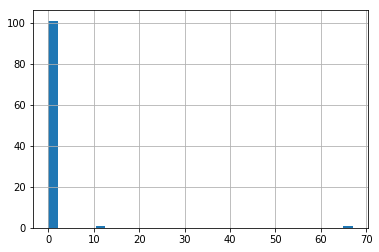

In [515]:
df.loc[df['Diabetes'].isna()]['Age'].hist(bins=32)
plt.show()

**Diabetes Age**

In [516]:
len(df[(df['DiabetesAge'].isna()) & (df['Diabetes'].isna())])

103

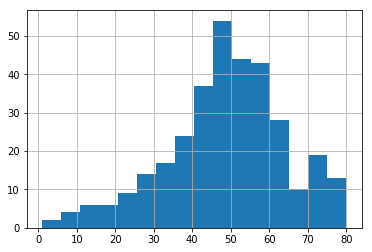

In [517]:
df['DiabetesAge'].hist(bins=16)
plt.show()

Most missing values for this features are because the individuals don't have diabetes. These entries are filled in with a 0. The instances where the data is actually missing is for the same individuals that had a missing value in the `Diabetes` column. Since these missing values were filled with No, the NaN values in the `DiabetesAge` column are also filled with 0. In short, all missing values in this column are filled in with the value 0.

**Health General**

In [518]:
df['HealthGen'].isna().sum()

1463

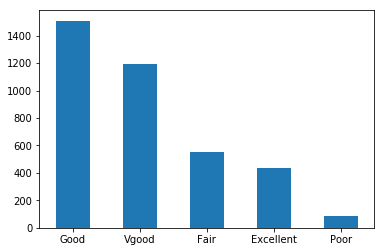

In [519]:
df['HealthGen'].value_counts().plot.bar(rot=0)
plt.show()

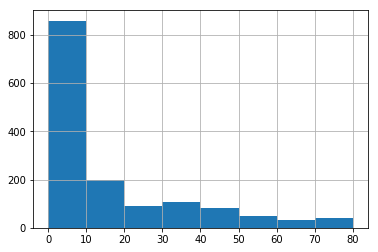

In [520]:
df.loc[df['HealthGen'].isna()]['Age'].hist(bins=8)
plt.show()

In [521]:
df.loc[df['Age'] <= 10]['HealthGen'].notna().sum()

0

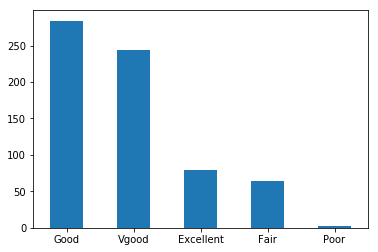

In [522]:
df.loc[df['Age'] <= 20]['HealthGen'].value_counts().plot.bar(rot=0)
plt.show()

Many missing values. Individuals with age <= 12 are filled in with Good. The remaining ones are filled by using the mean per age group.

**Days Mental Health Bad**

In [523]:
df['DaysMentHlthBad'].isna().sum()

1468

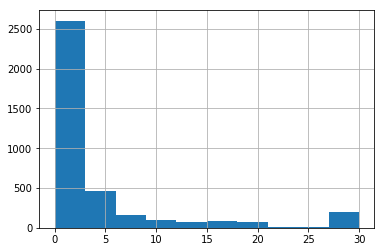

In [524]:
df['DaysMentHlthBad'].hist()
plt.show()

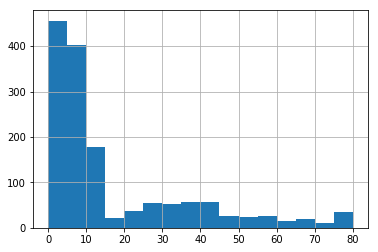

In [525]:
df.loc[df['DaysMentHlthBad'].isna()]['Age'].hist(bins=16)
plt.show()

Most missing values are in younger individuals. For individuals with `Age` $\le 12$ a value of 0 is filled in. The remaining ones are filled in using the mean value per age group.

**Little Interest**

In [526]:
df['LittleInterest'].isna().sum()

1954

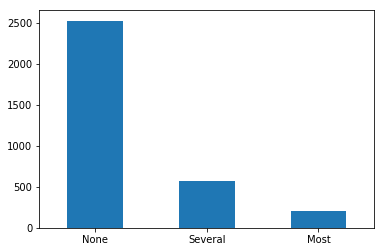

In [527]:
df['LittleInterest'].value_counts().plot.bar(rot=0)
plt.show()

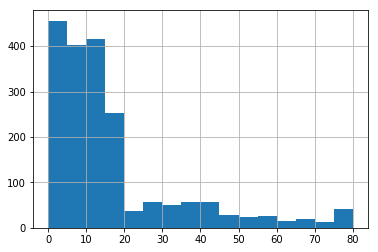

In [528]:
df.loc[df['LittleInterest'].isna()]['Age'].hist(bins=16)
plt.show()

Lots of missing data but most of it is from the younger individuals. It is assumed that people less than with `Age` $\le 15$ have a value of None and the rest are filled in by taking the most common label per age group. 

**Depressed**

In [529]:
df['Depressed'].isna().sum()

1951

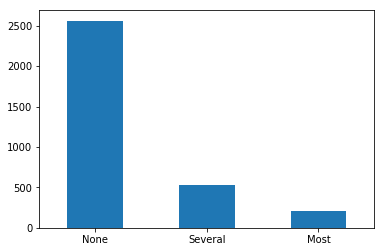

In [530]:
df['Depressed'].value_counts().plot.bar(rot=0)
plt.show()

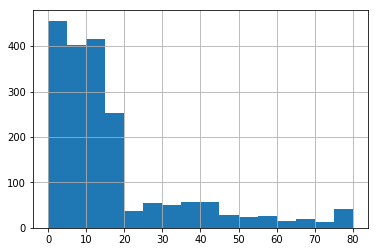

In [531]:
df.loc[df['Depressed'].isna()]['Age'].hist(bins=16)
plt.show()

Similarly to the `LittleInterest` feature, a large amount of the missing data is from the younger individuals. It is assumed that people less than with `Age` $\le 15$ have a value of 0 and the rest are filled in by taking the mean per age group. 

**Number Pregnancies**

In [532]:
len(df[(df['nPregnancies'].isna()) & (df['Gender']=='female')])

1370

In [533]:
len(df[df['nPregnancies']==0])

0

In [534]:
len(df[(df['nPregnancies'].isna()) & (df['nBabies']>0)])

0

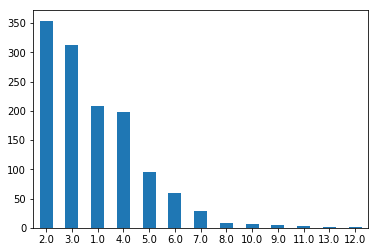

In [535]:
df['nPregnancies'].value_counts().plot.bar(rot=0)
plt.show()

In [536]:
len(df[(df['nPregnancies'].notna()) & (df['Gender']=='male')])

0

It looks like there is never the value 0. It is then assumed that a null value means that the individual has had 0 pregnancies. As a sanity check, there are no males that have had a pregnancy.

**Number Babies**

In [537]:
len(df[(df['nPregnancies'].notna()) & (df['nBabies']).isna()])

101

In [538]:
len(df[df['nBabies']==0])

4

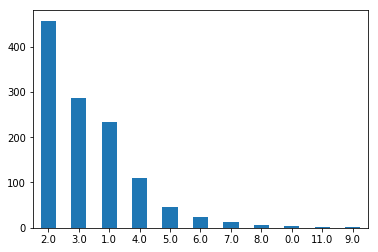

In [539]:
df['nBabies'].value_counts().plot.bar(rot=0)
plt.show()

How many instances have the amount of pregnancies different from the amount of babies?

In [540]:
len(df[(df['nPregnancies'] != df['nBabies']) & (df['nBabies'].notna())])

455

Are there instances where the amount of pregnancies is less than the amount of babies?

In [541]:
len(df[(df['nPregnancies'] < df['nBabies']) & (df['nBabies'].notna())])

0

In [542]:
len(df[(df['nPregnancies'].notna()) & (df['nBabies'].isna())])

101

Similarly to `nPregnancies`, all missing values are filled instances with missing `nBabies` and 0 `nPregnancies` are filled in with 0.

**Age 1st Baby**

In [543]:
len(df[(df['nBabies']!=0) & (df['Age1stBaby']).isna()])

4301

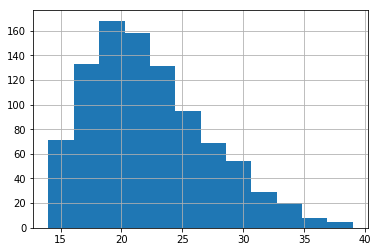

In [544]:
df['Age1stBaby'].hist(bins=12)
plt.show()

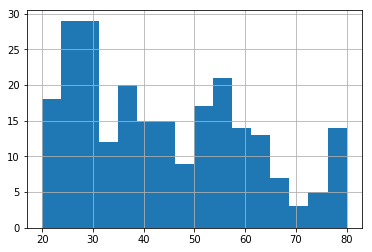

In [545]:
df.loc[(df['nBabies'].notna()) & (df['Age1stBaby'].isna())]['Age'].hist(bins=16)
plt.show()

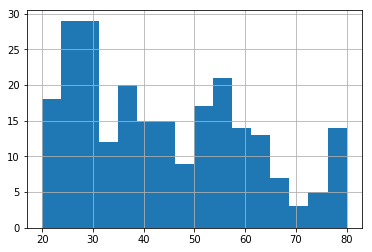

In [546]:
df.loc[(df['nBabies'].notna()) & (df['Age1stBaby'].isna())]['Age'].hist(bins=16)
plt.show()

The data appears to be normally distributed. Missing values where `nBabies` is 0 are filled in with 0.

**Sleep Hours Night**

In [547]:
df['SleepHrsNight'].isna().sum()

1367

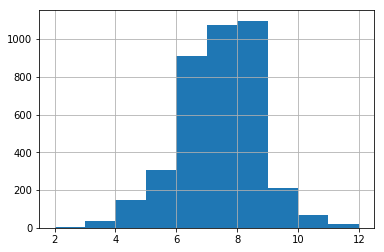

In [548]:
df['SleepHrsNight'].hist()
plt.show()

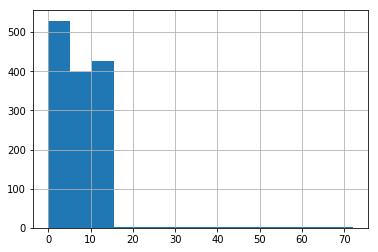

In [549]:
df.loc[df['SleepHrsNight'].isna()]['Age'].hist(bins=14)
plt.show()

In [550]:
age_count = list()
for i in range(df['Age'].max()):
    age_count += [(i, len(df.loc[(df['SleepHrsNight'].notna()) & (df['Age']==i)]))]
print(age_count)

[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 0), (16, 83), (17, 81), (18, 67), (19, 78), (20, 76), (21, 74), (22, 71), (23, 65), (24, 66), (25, 69), (26, 64), (27, 58), (28, 85), (29, 68), (30, 81), (31, 84), (32, 71), (33, 70), (34, 60), (35, 50), (36, 68), (37, 63), (38, 69), (39, 86), (40, 74), (41, 65), (42, 54), (43, 73), (44, 66), (45, 60), (46, 59), (47, 65), (48, 68), (49, 65), (50, 69), (51, 59), (52, 52), (53, 55), (54, 73), (55, 53), (56, 77), (57, 46), (58, 44), (59, 53), (60, 57), (61, 36), (62, 40), (63, 57), (64, 51), (65, 59), (66, 31), (67, 34), (68, 40), (69, 27), (70, 53), (71, 34), (72, 33), (73, 27), (74, 40), (75, 28), (76, 30), (77, 27), (78, 25), (79, 24)]


All individuals with `Age` $\le 15$ have missing values. For these instances the values are manually inputted by using the average sleep time got from. For the remaining people, the sleep hours per night is found using by taking the mean of the each group a particular person is part of.

**Sleep Trouble**

In [551]:
df['SleepTrouble'].isna().sum()

1356

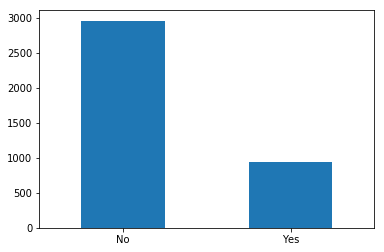

In [552]:
df['SleepTrouble'].value_counts().plot.bar(rot=0)
plt.show()

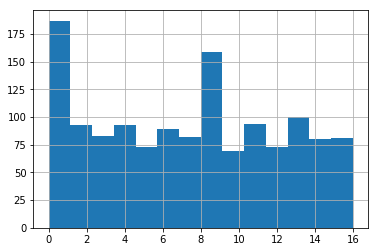

In [553]:
df.loc[df['SleepTrouble'].isna()]['Age'].hist(bins=14)
plt.show()

Since all missing values come from individuals with an age smaller or equal to 16. Maybe all these values can be assumed to be `No` as younger people are less likely to have sleep trouble.

**Physically Active**

In [554]:
df['PhysActive'].isna().sum()

1042

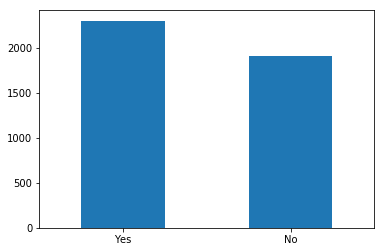

In [555]:
df['PhysActive'].value_counts().plot.bar(rot=0)
plt.show()

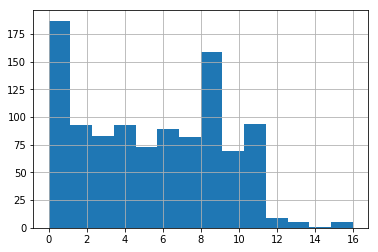

In [556]:
df.loc[df['PhysActive'].isna()]['Age'].hist(bins=14)
plt.show()

In [557]:
age_count = list()
for i in range(df['Age'].max()):
    age_count += [(i, len(df.loc[(df['PhysActive'].notna()) & (df['Age']==i)]))]
print(age_count)

[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 64), (13, 95), (14, 79), (15, 76), (16, 83), (17, 81), (18, 67), (19, 78), (20, 76), (21, 74), (22, 71), (23, 65), (24, 67), (25, 69), (26, 65), (27, 58), (28, 85), (29, 68), (30, 81), (31, 84), (32, 71), (33, 70), (34, 61), (35, 50), (36, 68), (37, 63), (38, 70), (39, 86), (40, 74), (41, 65), (42, 55), (43, 73), (44, 66), (45, 60), (46, 59), (47, 65), (48, 68), (49, 65), (50, 69), (51, 60), (52, 52), (53, 55), (54, 74), (55, 53), (56, 77), (57, 46), (58, 44), (59, 54), (60, 58), (61, 36), (62, 40), (63, 57), (64, 51), (65, 60), (66, 31), (67, 34), (68, 40), (69, 27), (70, 53), (71, 34), (72, 34), (73, 27), (74, 40), (75, 28), (76, 30), (77, 27), (78, 25), (79, 24)]


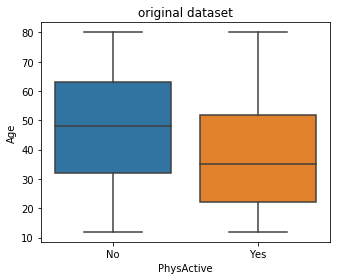

In [558]:
fig = plt.figure(figsize=(9,4))
ax1 = fig.add_subplot(1,2,1)
ax1 = sns.boxplot('PhysActive', 'Age', data=df)
ax1.set_title('original dataset')
plt.tight_layout()

For kids with `Age` $\le 4$ years old, `No` is inserted. All the individuals where $5 \ge$`Age` $15 \le$ are assumed to have physical activity. The remaining missing values for the population older than $15$ years old the most common value per age group is inserted.

**Physically Active Days**

In [559]:
df['PhysActiveDays'].isna().sum()

2872

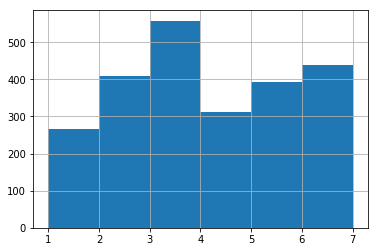

In [560]:
df['PhysActiveDays'].hist(bins=6)
plt.show()

There are too many missing values and as a result this column is dropped.

**TV Hours per Day**

In [561]:
df['TVHrsDay'].isna().sum()

2829

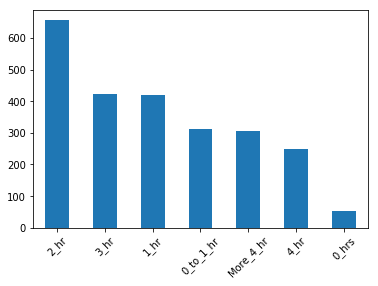

In [562]:
df['TVHrsDay'].value_counts().plot.bar(rot=45)
plt.show()

There are too many missing values and as a result this column is dropped.

**Computer Hours per Day**

In [563]:
df['CompHrsDay'].isna().sum()

2827

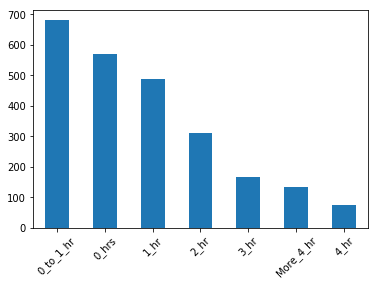

In [564]:
df['CompHrsDay'].value_counts().plot.bar(rot=45)
plt.show()

There are too many missing values and as a result this column is dropped.

**TV Hours per Day Child**

In [565]:
df['TVHrsDayChild'].isna().sum()

4829

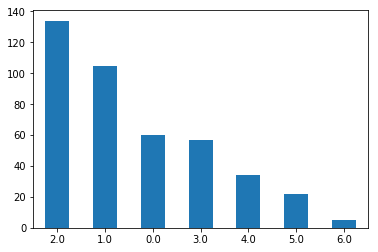

In [566]:
df['TVHrsDayChild'].value_counts().plot.bar(rot=0)
plt.show()

There are too many missing values and as a result this column is dropped.

**Computer Hours per Day Child**

In [567]:
df['TVHrsDayChild'].isna().sum()

4829

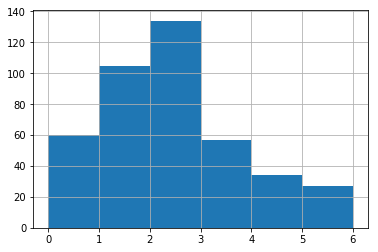

In [568]:
df['TVHrsDayChild'].hist(bins=6)
plt.show()

There are too many missing values and as a result this column is dropped.

**Alcohol 12+ Years**

In [569]:
df['Alcohol12PlusYr'].isna().sum()

2014

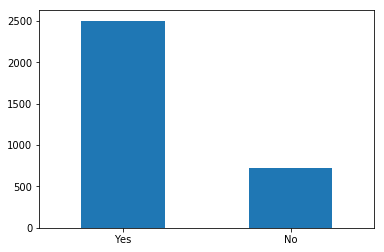

In [570]:
df['Alcohol12PlusYr'].value_counts().plot.bar(rot=0)
plt.show()

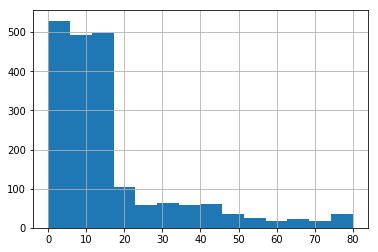

In [571]:
df.loc[df['Alcohol12PlusYr'].isna()]['Age'].hist(bins=14)
plt.show()

In [572]:
age_count = list()
for i in range(df['Age'].max()):
    age_count += [(i, len(df.loc[(df['Alcohol12PlusYr'].notna()) & (df['Age']==i)]))]
print(age_count)

[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 0), (16, 0), (17, 0), (18, 30), (19, 35), (20, 68), (21, 69), (22, 61), (23, 60), (24, 58), (25, 53), (26, 59), (27, 50), (28, 72), (29, 56), (30, 71), (31, 73), (32, 62), (33, 61), (34, 49), (35, 41), (36, 56), (37, 56), (38, 56), (39, 71), (40, 64), (41, 53), (42, 40), (43, 61), (44, 59), (45, 55), (46, 52), (47, 63), (48, 61), (49, 59), (50, 67), (51, 48), (52, 50), (53, 52), (54, 70), (55, 50), (56, 66), (57, 45), (58, 39), (59, 49), (60, 53), (61, 34), (62, 39), (63, 53), (64, 49), (65, 54), (66, 28), (67, 31), (68, 36), (69, 23), (70, 49), (71, 31), (72, 32), (73, 25), (74, 38), (75, 22), (76, 25), (77, 23), (78, 22), (79, 21)]


All values are missing for people younger than 18 years old. These are filled with a `No`. the remaining ones are filled by taking the most common value per age group each individual given is part of.

**Alcohol Day**

In [573]:
df['AlcoholDay'].isna().sum()

2842

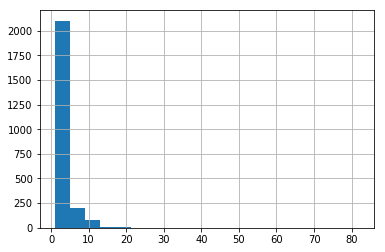

In [574]:
df['AlcoholDay'].hist(bins=20)
plt.show()

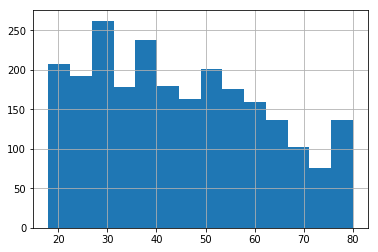

In [575]:
df.loc[df['AlcoholDay'].notna()]['Age'].hist(bins=14)
plt.show()

Again, people younger than 18 years old have all the values missing which are then filled with a 0. The remaining ones are filled by taking the most common value per age group each given individual is part of.

**Alcohol Year**

In [576]:
df['AlcoholYear'].isna().sum()

2364

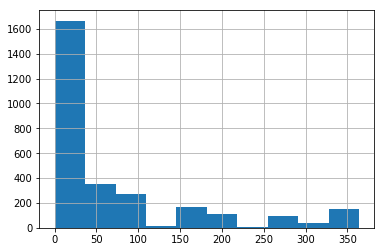

In [577]:
df['AlcoholYear'].hist()
plt.show()

Same as the `AlcoholDay` column, people younger than 18 years old have all the values missing which are then filled with a 0. The remaining ones are filled by taking the most common value per age group each given individual is part of.

**Smoke Now**

In [578]:
df['SmokeNow'].isna().sum()

3707

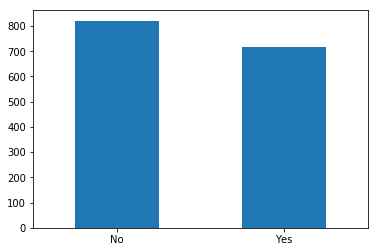

In [579]:
df['SmokeNow'].value_counts().plot.bar(rot=0)
plt.show()

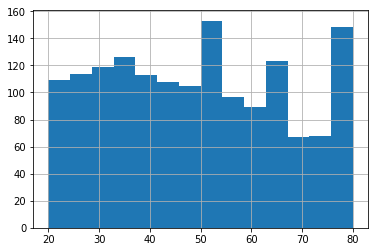

In [580]:
df.loc[df['SmokeNow'].notna()]['Age'].hist(bins=14)
plt.show()

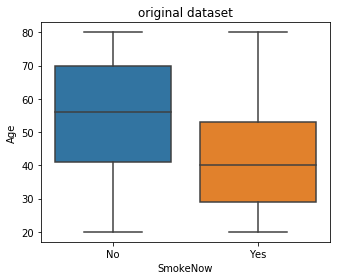

In [581]:
fig = plt.figure(figsize=(9,4))
ax1 = fig.add_subplot(1,2,1)
ax1 = sns.boxplot('SmokeNow', 'Age', data=df)
ax1.set_title('original dataset')
plt.tight_layout()

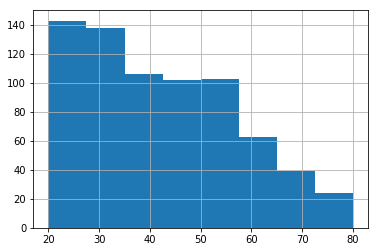

In [582]:
df.loc[df['SmokeNow']=='Yes']['Age'].hist(bins=8)
plt.show()

**Smoke Past 100 Months**

In [583]:
df['Smoke100'].isna().sum()

1665

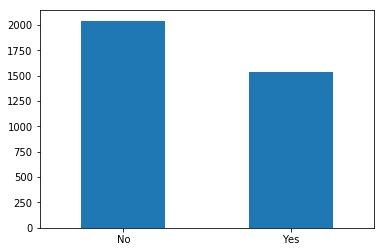

In [584]:
df['Smoke100'].value_counts().plot.bar(rot=0)
plt.show()

In [585]:
len(df.loc[(df['Smoke100'].isna()) & (df['Age']>=20)])

0

All missing values are from individuals younger than 20 years old. As hese people are assumed to not smoke, it follows that they should not identify as smokers. This means that all the missing values are filled in with `No`.

**Smoker Identify**

In [586]:
df['Smoke100n'].isna().sum()

1665

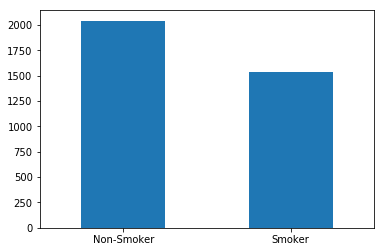

In [587]:
df['Smoke100n'].value_counts().plot.bar(rot=0)
plt.show()

Just like the `Smoke100` feature, all missing values are from individuals younger than 20 years old. Therefore, all these people it assumed that they do not smoke.

**Smoke Age**

In [588]:
df['SmokeAge'].isna().sum()

3767

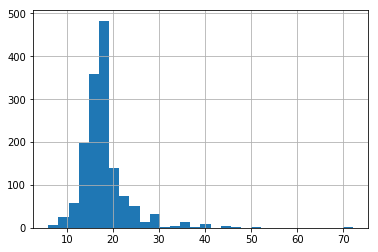

In [589]:
df['SmokeAge'].hist(bins=30)
plt.show()

In [590]:
len(df.loc[(df['SmokeNow']=='Yes') & (df['SmokeAge'].isna())])

15

Tha data appears to be normally distributed. The individuals which have the value `No` in the `SmokeNow` column have their entry filled with a 0. The few entries of `SmokeAge` of people that smoke but have a missing value are filled in by taking the mean of the age group a given individual is part of.

**Marijuana**

In [591]:
df['Marijuana'].isna().sum()

2835

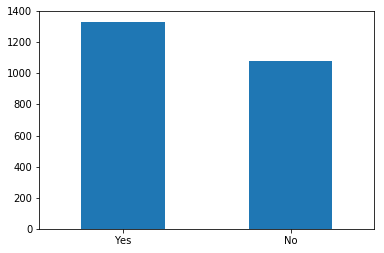

In [592]:
df['Marijuana'].value_counts().plot.bar(rot=0)
plt.show()

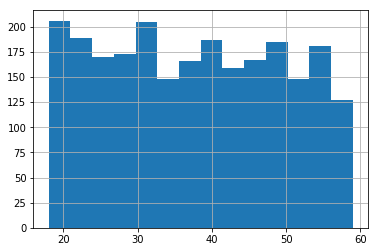

In [593]:
df.loc[df['Marijuana'].notna()]['Age'].hist(bins=14)
plt.show()

In [594]:
age_count = list()
for i in range(df['Age'].max()):
    age_count += [(i, len(df.loc[(df['Marijuana'].notna()) & (df['Age']==i)]))]
print(age_count)

[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 0), (16, 0), (17, 0), (18, 65), (19, 73), (20, 68), (21, 69), (22, 61), (23, 59), (24, 58), (25, 53), (26, 59), (27, 49), (28, 70), (29, 54), (30, 71), (31, 72), (32, 62), (33, 60), (34, 48), (35, 40), (36, 55), (37, 55), (38, 56), (39, 71), (40, 64), (41, 52), (42, 40), (43, 61), (44, 58), (45, 53), (46, 52), (47, 62), (48, 61), (49, 58), (50, 66), (51, 47), (52, 49), (53, 52), (54, 70), (55, 48), (56, 63), (57, 41), (58, 39), (59, 47), (60, 0), (61, 0), (62, 0), (63, 0), (64, 0), (65, 0), (66, 0), (67, 0), (68, 0), (69, 0), (70, 0), (71, 0), (72, 0), (73, 0), (74, 0), (75, 0), (76, 0), (77, 0), (78, 0), (79, 0)]


In [658]:
len(df.loc[(df['Marijuana'].isna()) & (df['SmokeNow']=='Yes')])

178

The individuals which have the value `No` in the `SmokeNow` column have their entry filled with a `No` in the `Marijuana` column as well.  

**Age First Marijuana**

In [596]:
df['AgeFirstMarij'].isna().sum()

3915

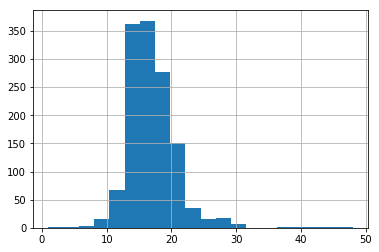

In [597]:
df['AgeFirstMarij'].hist(bins=20)
plt.show()

In [598]:
len(df.loc[(df['Marijuana']=='Yes') & (df['AgeFirstMarij'].isna())])

1

Most missing values are from people that do not smoke marijuana. The entries for these instance are therefore filled with a 0. The remaining missing values are filled with the mean of the age group the given individual is part of.

**Regular Marijuana**

In [599]:
df['RegularMarij'].isna().sum()

2835

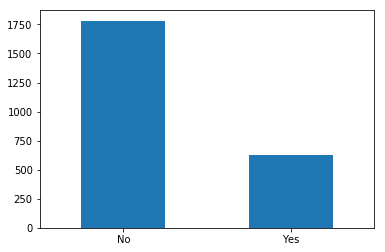

In [600]:
df['RegularMarij'].value_counts().plot.bar(rot=0)
plt.show()

In [659]:
len(df.loc[(df_test['Marijuana']=='Yes') & (df['RegularMarij'].isna())])

0

Instances that have `No` in the `Marijuana` feature have their missing value in `RegularMarij` set to `No` as well. The remaining missing values, if any, are filled in by using the most common value of the age group the given individual is part of.

**Age Regular Marijuana**

In [602]:
df['AgeRegMarij'].isna().sum()

4617

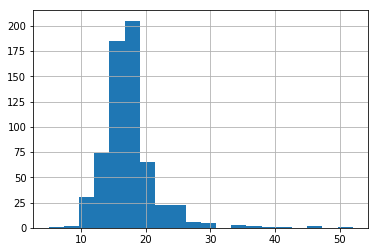

In [603]:
df['AgeRegMarij'].hist(bins=20)
plt.show()

In [604]:
len(df[(df['AgeRegMarij'].isna()) & (df['Marijuana'] == 'Yes')])

703

Similarly, instances that have `No` in the `Marijuana` feature have their missing value in `AgeRegMarij` set to 0. The remaining missing values, are filled in by using the mean value of the age group the given individual is part of.

**Hard Drugs**

In [605]:
df['HardDrugs'].isna().sum()

2448

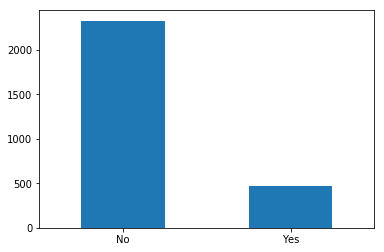

In [606]:
df['HardDrugs'].value_counts().plot.bar(rot=0)
plt.show()

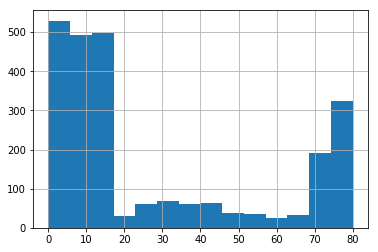

In [607]:
df.loc[df['HardDrugs'].isna()]['Age'].hist(bins=14)
plt.show()

In [608]:
age_count = list()
for i in range(df['Age'].max()):
    age_count += [(i, len(df.loc[(df['HardDrugs'].notna()) & (df['Age']==i)]))]
print(age_count)

[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 0), (16, 0), (17, 0), (18, 65), (19, 73), (20, 68), (21, 69), (22, 61), (23, 59), (24, 58), (25, 53), (26, 59), (27, 49), (28, 70), (29, 54), (30, 71), (31, 72), (32, 62), (33, 60), (34, 48), (35, 40), (36, 55), (37, 55), (38, 56), (39, 71), (40, 64), (41, 52), (42, 40), (43, 61), (44, 58), (45, 54), (46, 52), (47, 63), (48, 61), (49, 58), (50, 67), (51, 47), (52, 49), (53, 52), (54, 70), (55, 47), (56, 63), (57, 42), (58, 39), (59, 47), (60, 49), (61, 33), (62, 38), (63, 51), (64, 47), (65, 53), (66, 26), (67, 30), (68, 34), (69, 23), (70, 0), (71, 0), (72, 0), (73, 0), (74, 0), (75, 0), (76, 0), (77, 0), (78, 0), (79, 0)]


Instances where the value is missing and `Age` $\le 18$ have the `HardDrugs` attribute set to `No`. The remaining missing values, are filled in by using the most common value of the age group the given individual is part of.

**Sex Ever**

In [609]:
df['SexEver'].isna().sum()

2450

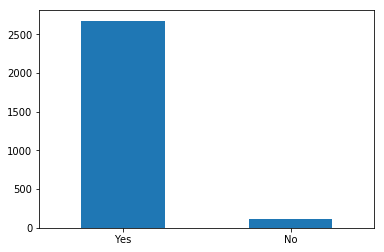

In [610]:
df['SexEver'].value_counts().plot.bar(rot=0)
plt.show()

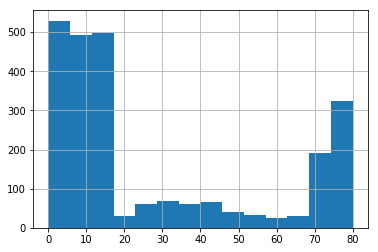

In [611]:
df.loc[df['SexEver'].isna()]['Age'].hist(bins=14)
plt.show()

People 

**Sex Age**

In [612]:
df['SexAge'].isna().sum()

2573

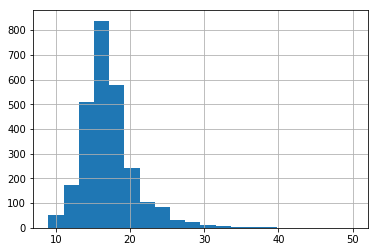

In [613]:
df['SexAge'].hist(bins=20)
plt.show()

In [614]:
len(df.loc[(df['SexAge'].isna()) & (df['SexEver'].notna())])

123

This feature appears to be normally distributed. Instances where `SexEver` is `No`

**Sex Number of Partners Life**

In [615]:
df['SexNumPartnLife'].isna().sum()

2473

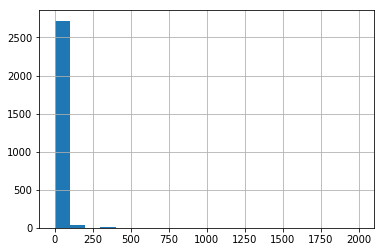

In [616]:
df['SexNumPartnLife'].hist(bins=20)
plt.show()

In [617]:
len(df[(df['SexNumPartnLife'].isna()) & (df['SexEver'] == 'Yes')])

23

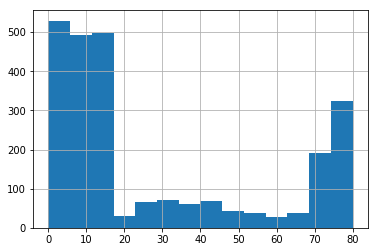

In [618]:
df.loc[df['SexNumPartnLife'].isna()]['Age'].hist(bins=14)
plt.show()

In [619]:
age_count = list()
for i in range(df['Age'].max()):
    age_count += [(i, len(df.loc[(df['SexNumPartnLife'].notna()) & (df['Age']==i)]))]
print(age_count)

[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 0), (16, 0), (17, 0), (18, 65), (19, 73), (20, 68), (21, 69), (22, 61), (23, 58), (24, 58), (25, 52), (26, 58), (27, 48), (28, 70), (29, 54), (30, 70), (31, 72), (32, 61), (33, 59), (34, 48), (35, 40), (36, 55), (37, 55), (38, 56), (39, 71), (40, 64), (41, 51), (42, 40), (43, 59), (44, 58), (45, 53), (46, 51), (47, 61), (48, 61), (49, 58), (50, 66), (51, 47), (52, 49), (53, 52), (54, 66), (55, 48), (56, 64), (57, 41), (58, 38), (59, 47), (60, 49), (61, 33), (62, 37), (63, 51), (64, 46), (65, 53), (66, 27), (67, 27), (68, 32), (69, 23), (70, 0), (71, 0), (72, 0), (73, 0), (74, 0), (75, 0), (76, 0), (77, 0), (78, 0), (79, 0)]


Missing values for people that have the `SexEver` attribute to `No` are filled in with 0. The remaining missing values are filled in by using the mean of the age group that the given individual is part of. However the dataset doesn't contain any value for people of 70 years or older. These values are filled in by using the mean of the instances with $60 \ge$ `SexNumPartnLife` $< 70$ as it is presumed that this value does not greatly change between the two age groups.

**Sex Number of Parners Year**

In [620]:
df['SexNumPartYear'].isna().sum()

2841

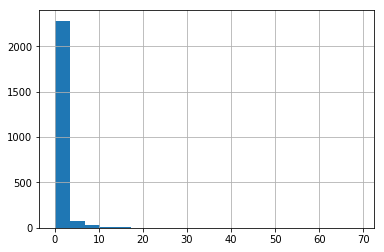

In [621]:
df['SexNumPartYear'].hist(bins=20)
plt.show()

In [622]:
len(df[(df['SexNumPartYear'].isna()) & (df['SexEver'] == 'Yes')])

382

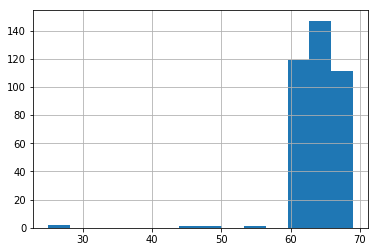

In [623]:
df.loc[(df['SexNumPartYear'].isna()) & (df['SexEver'] == 'Yes')]['Age'].hist(bins=14)
plt.show()

Similartly to `SexNumPartnLife`, missing values for people that have the `SexEver` attribute to `No` are filled in with 0. The remaining missing values are filled in by using the mean of the age group that the given individual is part of. However the dataset doesn't contain any value for people of 70 years or older. These values are filled in by using the mean of the instances with $60 \ge$ `SexNumPartnYear` $< 70$ as it is presumed that this value does not greatly change between the two age groups.

**Same Sex**

In [624]:
df['SameSex'].isna().sum()

2448

In [625]:
len(df.loc[(df['SameSex'].isna()) & (df['SexEver']=='No')])

0

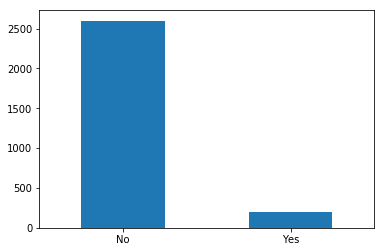

In [626]:
df['SameSex'].value_counts().plot.bar(rot=0)
plt.show()

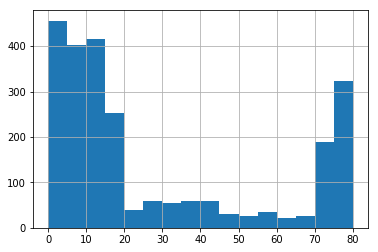

In [627]:
df.loc[df['SameSex'].isna()]['Age'].hist(bins=16)
plt.show()

Lots of missing values. Mostly for the younger and older age groups.

**Sex Orientation**

In [628]:
len(df.loc[(df['SexOrientation'].isna()) & (df['Age'] >= 14)])

1694

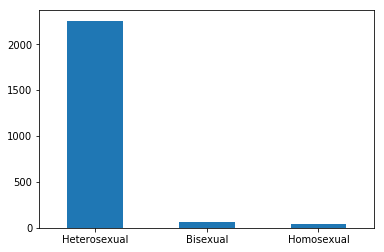

In [629]:
df['SexOrientation'].value_counts().plot.bar(rot=0)
plt.show()

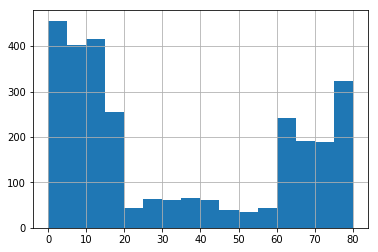

In [630]:
df.loc[df['SexOrientation'].isna()]['Age'].hist(bins=16)
plt.show()

This column is dropped as there are too many missing values.

**Pregnant Now**

In [631]:
len(df.loc[(df['PregnantNow'].isna()) & (df['Gender'] == 'female')])

1770

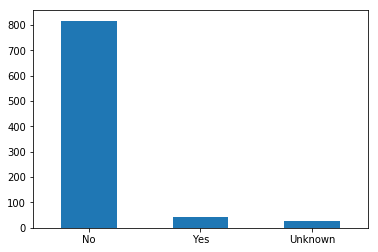

In [632]:
df['PregnantNow'].value_counts().plot.bar(rot=0)
plt.show()

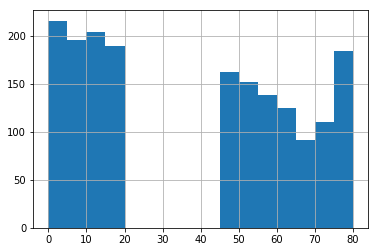

In [633]:
df.loc[(df['PregnantNow'].isna()) & (df['Gender'] == 'female')]['Age'].hist(bins=16)
plt.show()

All missing values are either from males or people that are less than 20 years old or more than 45 years old. As such it can be assumed that all individual with missing values are not pregnant.

**Flu**

In [634]:
df['flu'].isna().sum()

0

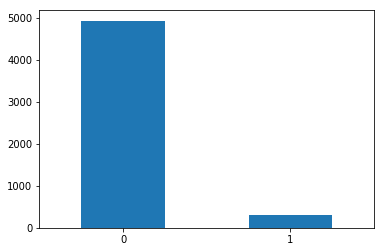

In [635]:
df['flu'].value_counts().plot.bar(rot=0)
plt.show()

There are no rows with flu value missing that would need to be dropped.

### Cleaning ###

In [636]:
def fill_bin_num(dataframe, feature, bin_feature, bin_size, stat_measure, min_bin=None, max_bin=None, default_val='No'):
    if min_bin is None:
        min_bin = dataframe[bin_feature].min()
    if max_bin is None:
        max_bin = dataframe[bin_feature].max()
    new_dataframe = dataframe.copy()
    df_meancat = pd.DataFrame(columns=['interval', 'stat_measure'])
    for num_bin, subset in dataframe.groupby(pd.cut(dataframe[bin_feature], np.arange(min_bin, max_bin+bin_size, bin_size), include_lowest=True)):
        if stat_measure is 'mean':
            row = [num_bin, subset[feature].mean()]
        elif stat_measure is 'mode': 
            mode_ar = subset[feature].mode().values
            if len(mode_ar) > 0:
                row = [num_bin, mode_ar[0]]
            else:
                row = [num_bin, default_val]
        else:
            raise Exception('Unknown statistical measure: ' + stat_measure)
        df_meancat.loc[len(df_meancat)] = row
    for index, row_df in dataframe[dataframe[feature].isna()].iterrows():
        for _, row_meancat in df_meancat.iterrows():
            if row_df[bin_feature] in row_meancat['interval']:
                new_dataframe.at[index, feature] = row_meancat['stat_measure']
    return new_dataframe

In [637]:
# def fill_bin_cat(dataframe, feature, category):
#     new_dataframe = dataframe.copy()
#     df_modecat = pd.DataFrame(columns=['interval', 'mode'])
#     for age_bin, subset in dataframe.groupby(dataframe[category]):
#         row = [age_bin, subset[feature].mode.values[0]]
#         df_modecat.loc[len(df_modecat)] = row
#     for index, row_df in df[df[feature].isna()].iterrows():
#         for _, row_meancat in df_modecat.iterrows():
#             if row_df[category] in row_meancat['interval']:
#                 new_dataframe.at[index, feature] = row_meancat['mode']
#     return new_dataframe

In [638]:
def make_dummy_cols(dataframe, column, prefix, drop_dummy):
    dummy = pd.get_dummies(dataframe[column], prefix=prefix)
    dummy = dummy.drop(columns=prefix+'_'+drop_dummy)
    dataframe = pd.concat([dataframe, dummy], axis=1)
    dataframe = dataframe.drop(columns=column)
    return dataframe

In [639]:
def cleaning(dataframe_raw):
    dataframe = dataframe_raw.copy()

    dataframe = dataframe.set_index('ID')

    dataframe.loc[(dataframe['Age']<=13) & (dataframe['Education'].isna()), 'Education'] = 'Lower School/Kindergarten'
    dataframe.loc[(dataframe['Age']==14) & (dataframe['Education'].isna()), 'Education'] = '8th Grade'
    dataframe.loc[(dataframe['Age']<=17) & (dataframe['Education'].isna()), 'Education'] = '9 - 11th Grade'
    dataframe.loc[(dataframe['Age']<=21) & (dataframe['Education'].isna()), 'Education'] = 'High School'
    dataframe['Education'] = dataframe['Education'].fillna('Some College')

    dataframe.loc[(dataframe['Age']<=20) & (dataframe['MaritalStatus'].isna()), 'MaritalStatus'] = 'NeverMarried'
    dataframe.at[dataframe['MaritalStatus'].isna(), 'MaritalStatus'] = 'Married'  # For now this is hardcoded

    dataframe = dataframe.drop(columns=['HHIncome'])

    dataframe.loc[dataframe['HHIncomeMid'].isna(), 'HHIncomeMid'] = dataframe['HHIncomeMid'].mean()

    dataframe.loc[dataframe['Poverty'].isna(), 'Poverty'] = dataframe['Poverty'].mean()

    dataframe.loc[dataframe['HomeRooms'].isna(), 'HomeRooms'] = dataframe['HomeRooms'].mean()

    dataframe.loc[dataframe['HomeOwn'].isna(), 'HomeOwn'] = dataframe['HomeOwn'].mode().values[0]

    dataframe.loc[(dataframe['Work'].isna()) & (dataframe['Education'].isna()) & (dataframe['Age']<=20), 'Work'] = 'NotWorking'

    dataframe.loc[dataframe['Work'].isna(), 'Work'] = dataframe['Work'].mode().values[0]

    dataframe = fill_bin_num(dataframe, 'Weight', 'Age', 2, 'mean')

    dataframe = dataframe.drop(columns=['HeadCirc'])

    for index, row in dataframe.iterrows():
        if np.isnan(row['Height']) and not np.isnan(row['Length']):
            dataframe.at[index, 'Height'] = row['Length']
    dataframe = fill_bin_num(dataframe, 'Height', 'Age', 2, 'mean')

    dataframe = dataframe.drop(columns=['Length'])

    for index, row in dataframe[dataframe['BMI'].isna()].iterrows():
        dataframe.at[index, 'BMI'] = row['Weight'] / ((row['Height']/100)**2)

    dataframe = dataframe.drop(columns='BMICatUnder20yrs')

    dataframe = dataframe.drop(columns='BMI_WHO')

    dataframe = fill_bin_num(dataframe, 'Pulse', 'Age', 10, 'mean')

    dataframe.loc[(dataframe['Age']<10) & (dataframe['BPSysAve'].isna()), 'BPSysAve'] = 105
    dataframe = fill_bin_num(dataframe, 'BPSysAve', 'Age', 5, 'mean', 10)

    dataframe.loc[(dataframe['Age']<10) & (dataframe['BPDiaAve'].isna()), 'BPDiaAve'] = 60
    dataframe = fill_bin_num(dataframe, 'BPDiaAve', 'Age', 5, 'mean', 10)

    dataframe = dataframe.drop(columns='BPSys1')

    dataframe = dataframe.drop(columns='BPDia1')

    dataframe = dataframe.drop(columns='BPSys2')

    dataframe = dataframe.drop(columns='BPDia2')

    dataframe = dataframe.drop(columns='BPSys3')

    dataframe = dataframe.drop(columns='BPDia3')

    dataframe = dataframe.drop(columns=['Testosterone'])

    dataframe.loc[(dataframe['Age']<10) & (dataframe['DirectChol'].isna()), 'DirectChol'] = 0 
    dataframe = fill_bin_num(dataframe, 'DirectChol', 'Age', 5, 'mean', 10)

    dataframe.loc[(dataframe['Age']<10) & (dataframe['TotChol'].isna()), 'TotChol'] = 0
    dataframe = fill_bin_num(dataframe, 'TotChol', 'Age', 5, 'mean', 10)
    
    dataframe = dataframe.drop(columns=['UrineVol1'])

    dataframe = dataframe.drop(columns=['UrineFlow1'])

    dataframe = dataframe.drop(columns=['UrineVol2'])

    dataframe = dataframe.drop(columns=['UrineFlow2'])

    dataframe['Diabetes'] = dataframe['Diabetes'].fillna('No')

    dataframe['DiabetesAge'] = dataframe['DiabetesAge'].fillna(0)

    dataframe.loc[(dataframe['Age']<=12) & (dataframe['HealthGen'].isna()), 'HealthGen'] = 'Good'
    dataframe = fill_bin_num(dataframe, 'HealthGen', 'Age', 5, 'mode', 10)

    dataframe.loc[(dataframe['Age']<=12) & (dataframe['DaysMentHlthBad'].isna()), 'DaysMentHlthBad'] = 0
    dataframe = fill_bin_num(dataframe, 'DaysMentHlthBad', 'Age', 5, 'mean', 10)

    dataframe.loc[(dataframe['Age']<=15) & (dataframe['LittleInterest'].isna()), 'LittleInterest'] = 'None'
    dataframe = fill_bin_num(dataframe, 'LittleInterest', 'Age', 5, 'mode', 15)

    dataframe.loc[(dataframe['Age']<=12) & (dataframe['DaysMentHlthBad'].isna()), 'DaysMentHlthBad'] = 0
    dataframe = fill_bin_num(dataframe, 'DaysMentHlthBad', 'Age', 5, 'mean', 10)

    for index, row in dataframe.iterrows():
        if np.isnan(row['nBabies']) and not np.isnan(row['nPregnancies']):
            dataframe.at[index, 'nBabies'] = row['nPregnancies']
    dataframe['nBabies'] = dataframe['nBabies'].fillna(0)

    dataframe['nPregnancies'] = dataframe['nPregnancies'].fillna(0)

    dataframe['Age1stBaby'] = dataframe['Age1stBaby'].fillna(0)

    dataframe.loc[(dataframe['Age']==0) & (dataframe['SleepHrsNight'].isna()), 'SleepHrsNight'] = 14
    dataframe.loc[(dataframe['Age']<=2) & (dataframe['SleepHrsNight'].isna()), 'SleepHrsNight'] = 12
    dataframe.loc[(dataframe['Age']<=5) & (dataframe['SleepHrsNight'].isna()), 'SleepHrsNight'] = 10
    dataframe.loc[(dataframe['Age']<=10) & (dataframe['SleepHrsNight'].isna()), 'SleepHrsNight'] = 9
    dataframe.loc[(dataframe['Age']<=15) & (dataframe['SleepHrsNight'].isna()), 'SleepHrsNight'] = 8
    dataframe['SleepHrsNight'] = dataframe['SleepHrsNight'].fillna(dataframe_raw['SleepHrsNight'].mean())

    dataframe['SleepTrouble'] = dataframe['SleepTrouble'].fillna('No')

    dataframe.loc[(dataframe['Age']<=4) & (dataframe['PhysActive'].isna()), 'PhysActive'] = 'No'
    dataframe = fill_bin_num(dataframe, 'PhysActive', 'Age', 2, 'mode', 16)
    dataframe['PhysActive'] = dataframe['PhysActive'].fillna('Yes') # Big assumption here. All kids between 4 and 16 are physically active

    dataframe = dataframe.drop(columns=['PhysActiveDays'])

    dataframe = dataframe.drop(columns=['TVHrsDay'])

    dataframe = dataframe.drop(columns=['TVHrsDayChild'])

    dataframe = dataframe.drop(columns=['CompHrsDay'])

    dataframe = dataframe.drop(columns=['CompHrsDayChild'])

    dataframe.loc[(dataframe['Age']<18) & (dataframe['Alcohol12PlusYr'].isna()), 'Alcohol12PlusYr'] = 'No'
    dataframe = fill_bin_num(dataframe, 'Alcohol12PlusYr', 'Age', 5, 'mode', 18)

    dataframe.loc[(dataframe['Age']<18) & (dataframe['AlcoholDay'].isna()), 'AlcoholDay'] = 0
    dataframe = fill_bin_num(dataframe, 'AlcoholDay', 'Age', 5, 'mean', 18)

    dataframe.loc[(dataframe['Age']<18) & (dataframe['AlcoholYear'].isna()), 'AlcoholYear'] = 0
    dataframe = fill_bin_num(dataframe, 'AlcoholYear', 'Age', 5, 'mean', 18)

    dataframe.loc[(dataframe['Age']<20) & (dataframe['SmokeNow'].isna()), 'SmokeNow'] = 'No'
    dataframe = fill_bin_num(dataframe, 'SmokeNow', 'Age', 5, 'mode', 20)

    dataframe['Smoke100'] = dataframe['Smoke100'].fillna('No')

    dataframe['Smoke100n'] = dataframe['Smoke100'].fillna('No')

    dataframe.loc[(dataframe['SmokeNow']=='No') & (dataframe['SmokeAge'].isna()), 'SmokeAge'] = 0
    dataframe = fill_bin_num(dataframe, 'SmokeAge', 'Age', 5, 'mean', 20)

    dataframe.loc[(dataframe['Age']<18) & (dataframe['Marijuana'].isna()), 'Marijuana'] = 'No'
    dataframe.loc[(dataframe['Marijuana'].isna()) & (dataframe['SmokeNow']=='No'), 'Marijuana'] = 'No'
    dataframe = fill_bin_num(dataframe, 'Marijuana', 'Age', 5, 'mode', 20)

    dataframe.loc[(dataframe['Marijuana']=='No') & (dataframe['AgeFirstMarij'].isna()), 'AgeFirstMarij'] = 0
    dataframe = fill_bin_num(dataframe, 'AgeFirstMarij', 'Age', 5, 'mean', 20)

    dataframe.loc[(dataframe['Marijuana']=='No') & (dataframe['RegularMarij'].isna()), 'RegularMarij'] = 'No'
    dataframe = fill_bin_num(dataframe, 'RegularMarij', 'Age', 5, 'mode', 20)

    dataframe.loc[(dataframe['RegularMarij']=='No') & (dataframe['AgeRegMarij'].isna()), 'AgeRegMarij'] = 0
    dataframe = fill_bin_num(dataframe, 'AgeRegMarij', 'Age', 5, 'mean', 20)

    dataframe.loc[(dataframe['Age']<18) & (dataframe['HardDrugs'].isna()), 'HardDrugs'] = 'No'
    dataframe = fill_bin_num(dataframe, 'HardDrugs', 'Age', 5, 'mode', 18)

    mode_sex_age = dataframe['SexAge'].mode()[0]
    dataframe.loc[(dataframe['Age']<=mode_sex_age) & (dataframe['SexEver'].isna()), 'SexEver'] = 'No'
    dataframe['SexEver'] = dataframe['SexEver'].fillna('Yes')

    dataframe.loc[(dataframe['SexEver']=='No') & (dataframe['SexAge'].isna()), 'SexAge'] = 0
    dataframe.loc[(dataframe['SexAge'].isna() & (dataframe['Age']<mode_sex_age)), 'SexAge'] = dataframe.loc[(dataframe['SexAge'].isna() & (dataframe['Age']<mode_sex_age)), 'Age']
    dataframe['SexAge'] = dataframe['SexAge'].fillna(mode_sex_age)

    dataframe.loc[(dataframe['SexEver']=='No') & (dataframe['SexNumPartnLife'].isna()), 'SexNumPartnLife'] = 0
    dataframe = fill_bin_num(dataframe, 'SexNumPartnLife', 'Age', 5, 'mean')
    dataframe['SexNumPartnLife'] = dataframe_raw.loc[(dataframe_raw['Age'] >= 60) & (dataframe_raw['Age'] <= 70), 'SexNumPartnLife'].mode()[0] # Missing values for the elderly. Assumed that lifetime sex partners do not increase after 60.

    dataframe.loc[(dataframe['SexEver']=='No') & (dataframe['SexNumPartYear'].isna()), 'SexNumPartYear'] = 0
    dataframe = fill_bin_num(dataframe, 'SexNumPartYear', 'Age', 10, 'mean')
    dataframe['SexNumPartYear'] = dataframe['SexNumPartYear'].fillna(0)

    dataframe = dataframe.drop(columns=['SameSex'])

    dataframe = dataframe.drop(columns=['SexOrientation']) # Maybe this should not be dropped

    dataframe['PregnantNow'] = dataframe['PregnantNow'].fillna('No')


    # Making dummy variables
    dataframe['male'] = 1*(dataframe['Gender'] ==  'male')
    dataframe = dataframe.drop(columns=['Gender'])

    dataframe['white'] = np.where(dataframe['Race1'] == 'white',1,0)
    dataframe = dataframe.drop(columns=['Race1'])

    dataframe = make_dummy_cols(dataframe, 'Education', 'education', '8th Grade')

    dataframe = make_dummy_cols(dataframe, 'MaritalStatus', 'maritalstatus', 'Separated')

    dataframe = make_dummy_cols(dataframe, 'HomeOwn', 'homeown', 'Other')

    dataframe = make_dummy_cols(dataframe, 'Work', 'work', 'Looking')

    dataframe['Diabetes'] = np.where(dataframe['Diabetes'] == 'Yes',1,0)

    dataframe = make_dummy_cols(dataframe, 'HealthGen', 'healthgen', 'Poor')

    dataframe = make_dummy_cols(dataframe, 'LittleInterest', 'littleinterest', 'None')

    dataframe = make_dummy_cols(dataframe, 'Depressed', 'depressed', 'None')

    dataframe['SleepTrouble'] = np.where(dataframe['SleepTrouble'] == 'Yes',1,0)

    dataframe['PhysActive'] = np.where(dataframe['PhysActive'] == 'Yes',1,0)

    dataframe['Alcohol12PlusYr'] = np.where(dataframe['Alcohol12PlusYr'] == 'Yes',1,0)

    dataframe['SmokeNow'] = np.where(dataframe['SmokeNow'] == 'Yes',1,0)
    
    dataframe['Smoke100'] = np.where(dataframe['Smoke100'] == 'Yes',1,0)

    dataframe['Smoke100n'] = np.where(dataframe['Smoke100n'] == 'Yes',1,0)

    dataframe['Marijuana'] = np.where(dataframe['Marijuana'] == 'Yes',1,0)

    dataframe['RegularMarij'] = np.where(dataframe['RegularMarij'] == 'Yes',1,0)

    dataframe['HardDrugs'] = np.where(dataframe['HardDrugs'] == 'Yes',1,0)

    dataframe['SexEver'] = np.where(dataframe['SexEver'] == 'Yes',1,0)

    # dataframe['Heterosexual'] = np.where(dataframe['SexOrientation'] == 'Heterosexual',1,0)
    # dataframe = dataframe.drop(columns=['SexOrientation']) 

    dataframe['PregnantNow'] = np.where(dataframe['PregnantNow'] == 'Yes',1,0)

    return dataframe

In [640]:
df_clean = cleaning(df)

In [641]:
df_clean.count()

Age                                    5246
HHIncomeMid                            5246
Poverty                                5246
HomeRooms                              5246
Weight                                 5246
Height                                 5246
BMI                                    5246
Pulse                                  5246
BPSysAve                               5246
BPDiaAve                               5246
DirectChol                             5246
TotChol                                5246
Diabetes                               5246
DiabetesAge                            5246
DaysMentHlthBad                        5246
nPregnancies                           5246
nBabies                                5246
Age1stBaby                             5246
SleepHrsNight                          5246
SleepTrouble                           5246
PhysActive                             5246
Alcohol12PlusYr                        5246
AlcoholDay                      

In [642]:
df_clean.shape

(5246, 63)

In [643]:
df_clean.head()

Age  HHIncomeMid  Poverty  HomeRooms  Weight  Height    BMI  Pulse  \
ID                                                                          
51624   34      30000.0     1.36        6.0    87.4   164.7  32.22   70.0   
51630   49      40000.0     1.91        5.0    86.7   168.4  30.57   86.0   
51638    9      87500.0     1.84        6.0    29.8   133.1  16.82   82.0   
51646    8      60000.0     2.33        7.0    35.2   130.6  20.64   72.0   
51647   45      87500.0     5.00        6.0    75.7   166.7  27.24   62.0   

       BPSysAve  BPDiaAve  DirectChol  TotChol  Diabetes  DiabetesAge  \
ID                                                                      
51624     113.0      85.0        1.29     3.49         0          0.0   
51630     112.0      75.0        1.16     6.70         0          0.0   
51638      86.0      47.0        1.34     4.86         0          0.0   
51646     107.0      37.0        1.55     4.09         0          0.0   
51647     118.0      64.0        2.12     5.82         0          0.0   

       DaysMentHlthBad  nPregnancies  nBabies  Age1stBaby  SleepHrsNight  \
ID                                                                         
51624             15.0           0.0      0.0         0.0            4.0   
51630             10.0           2.0      2.0        27.0            8.0   
51638              0.0           0.0      0.0         0.0            9.0   
51646              0.0           0.0      0.0         0.0            9.0   
51647              3.0           1.0      1.0         0.0            8.0   

       SleepTrouble  PhysActive  Alcohol12PlusYr  AlcoholDay  AlcoholYear  \
ID                                                                          
51624             1           0                1    3.190244          0.0   
51630             1           0                1    2.000000         20.0   
51638             0           1                0    0.000000          0.0   
51646             0           1                0    0.000000          0.0   
51647             0           1                1    3.000000         52.0   

       SmokeNow  Smoke100  Smoke100n   SmokeAge  Marijuana  AgeFirstMarij  \
ID                                                                          
51624         0         1          1  18.000000          1           17.0   
51630         1         1          1  38.000000          1           18.0   
51638         0         0          0   0.000000          0            0.0   
51646         0         0          0   0.000000          0            0.0   
51647         1         0          0  17.099237          1           13.0   

       RegularMarij  AgeRegMarij  HardDrugs  SexEver  SexAge  SexNumPartnLife  \
ID                                                                              
51624             0          0.0          1        1    16.0              1.0   
51630             0          0.0          1        1    12.0              1.0   
51638             0          0.0          0        0     0.0              1.0   
51646             0          0.0          0        0     0.0              1.0   
51647             0          0.0          0        1    13.0              1.0   

       SexNumPartYear  PregnantNow  flu  male  white  \
ID                                                     
51624             1.0            0    0     1      0   
51630             1.0            0    0     0      0   
51638             0.0            0    0     1      0   
51646             0.0            0    0     1      0   
51647             0.0            0    0     0      0   

       education_9 - 11th Grade  education_College Grad  \
ID                                                        
51624                         0                       0   
51630                         0                       0   
51638                         0                       0   
51646                         0                       0   
51647                      

In [644]:
df_clean.describe()

Age    HHIncomeMid      Poverty    HomeRooms       Weight  \
count  5246.000000    5246.000000  5246.000000  5246.000000  5246.000000   
mean     35.078155   54079.824927     2.614229     6.147025    68.732674   
std      23.032443   31517.694962     1.607039     2.216043    29.715541   
min       0.000000    2500.000000     0.000000     1.000000     2.800000   
25%      15.000000   30000.000000     1.160000     5.000000    53.100000   
50%      33.000000   50000.000000     2.614229     6.000000    70.700000   
75%      53.000000   87500.000000     4.120000     7.000000    87.200000   
max      80.000000  100000.000000     5.000000    13.000000   223.000000   

            Height          BMI        Pulse     BPSysAve     BPDiaAve  \
count  5246.000000  5246.000000  5246.000000  5246.000000  5246.000000   
mean    157.208144    26.040690    74.718047   115.980419    65.701755   
std      26.273228     7.514485    11.570264    16.522264    13.792470   
min      47.100000    12.621652    40.000000    76.000000     0.000000   
25%     153.825000    20.600000    66.000000   105.000000    60.000000   
50%     164.400000    25.430000    74.919162   113.000000    66.000000   
75%     173.200000    30.267500    82.303571   124.000000    74.000000   
max     200.400000    80.600000   134.000000   226.000000   116.000000   

        DirectChol      TotChol     Diabetes  DiabetesAge  DaysMentHlthBad  \
count  5246.000000  5246.000000  5246.000000  5246.000000      5246.000000   
mean      1.200521     4.269880     0.076630     3.103698         3.177705   
std       0.559661     1.829607     0.266029    12.616040         6.707996   
min       0.000000     0.000000     0.000000     0.000000         0.000000   
25%       1.010000     3.800000     0.000000     0.000000         0.000000   
50%       1.270000     4.550000     0.000000     0.000000         0.000000   
75%       1.500000     5.350000     0.000000     0.000000         3.778878   
max       4.030000    13.650000     1.000000    80.000000        30.000000   

       nPregnancies      nBabies   Age1stBaby  SleepHrsNight  SleepTrouble  \
count   5246.000000  5246.000000  5246.000000    5246.000000   5246.000000   
mean       0.748380     0.600076     4.026115       7.617416      0.178040   
std        1.571424     1.251954     8.842154       1.895974      0.382583   
min        0.000000     0.000000     0.000000       2.000000      0.000000   
25%        0.000000     0.000000     0.000000       6.000000      0.000000   
50%        0.000000     0.000000     0.000000       8.000000      0.000000   
75%        0.000000     0.000000     0.000000       8.000000      0.000000   
max       13.000000    11.000000    39.000000      14.000000      1.000000   

        PhysActive  Alcohol12PlusYr   AlcoholDay  AlcoholYear     SmokeNow  \
count  5246.000000      5246.000000  5246.000000  5246.000000  5246.000000   
mean      0.549943         0.571483     2.074333    51.034473     0.383530   
std       0.497547         0.494911     2.778252    82.305586     0.486292   
min       0.000000         0.000000     0.000000     0.000000     0.000000   
25%       0.000000         0.000000     0.000000     0.000000     0.000000   
50%       1.000000         1.000000     1.635135    12.000000     0.000000   
75%       1.000000         1.000000     3.000000    68.192308     1.000000   
max       1.000000         1.000000    82.000000   364.000000     1.000000   

          Smoke100    Smoke100n     SmokeAge    Marijuana  AgeFirstMarij  \
count  5246.000000  5246.000000  5246.000000  5246.000000    5246.000000   
mean      0.293366     0.293366     9.218582     0.296416       4.708799   
std       0.455348     0.455348     9.142674     0.456720       7.653371   
min       0.000000     0.000000     0.000000     0.000000       0.000000   
25%       0.000000     0.000000     0.000000     0.000000       0.000000   
50%       0.000000     0.000000    13.000000     0.000000       0.000000   
75%       1.000000    

In [645]:
df_clean.dtypes

Age                                      int64
HHIncomeMid                            float64
Poverty                                float64
HomeRooms                              float64
Weight                                 float64
Height                                 float64
BMI                                    float64
Pulse                                  float64
BPSysAve                               float64
BPDiaAve                               float64
DirectChol                             float64
TotChol                                float64
Diabetes                                 int64
DiabetesAge                            float64
DaysMentHlthBad                        float64
nPregnancies                           float64
nBabies                                float64
Age1stBaby                             float64
SleepHrsNight                          float64
SleepTrouble                             int64
PhysActive                               int64
Alcohol12Plus

In [646]:
df_clean.shape

(5246, 63)

### Analysing correlations between different features ###

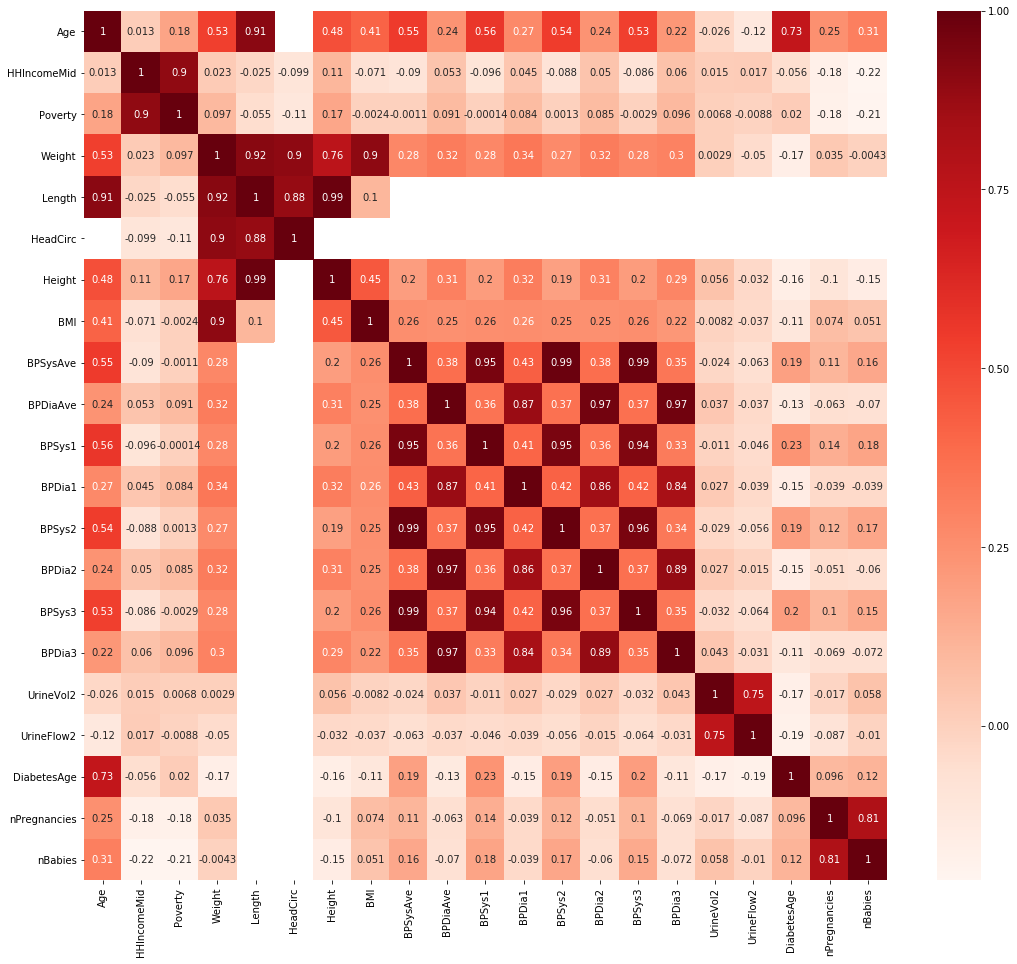

In [647]:
corr_pairs = list()

correlations = df.corr()
for col_name, _ in correlations.iteritems():
    drop = True
    for row_name, _ in correlations.iterrows():
        if row_name != col_name:
            if correlations.loc[row_name, col_name] > 0.7:
                drop = False
                corr_pairs += [(col_name, row_name)]
            # else:
            #     correlations.loc[row_name, col_name] = 0   
    if drop:
        correlations = correlations.drop(columns=col_name)
        correlations = correlations.drop(col_name)
plt.figure(figsize=(18,16))
sns.heatmap(correlations, annot=True, cmap=plt.cm.Reds)
plt.show()

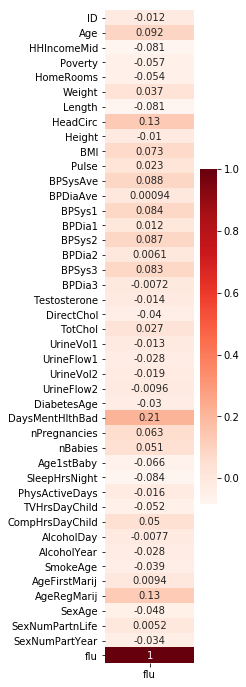

In [648]:
cors = df.corr()['flu'].to_frame()
plt.figure(figsize=(2,12))
sns.heatmap(cors, annot=True, cmap=plt.cm.Reds)
plt.show()

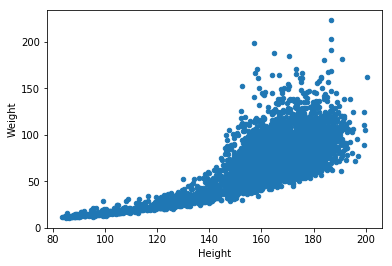

In [649]:
df.plot.scatter('Height', 'Weight')
plt.show()

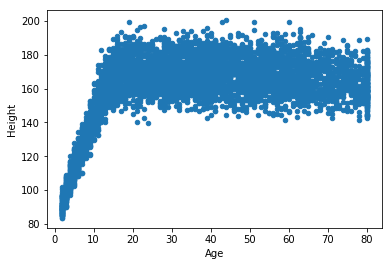

In [650]:
df.plot.scatter('Age', 'Height')
plt.show()

In [651]:
df[['HHIncomeMid', 'HomeRooms']].corr()

HHIncomeMid  HomeRooms
HHIncomeMid     1.000000   0.458009
HomeRooms       0.458009   1.000000

In [652]:
df.describe()

ID          Age    HHIncomeMid      Poverty    HomeRooms  \
count   5246.000000  5246.000000    4798.000000  4843.000000  5210.000000   
mean   61707.937286    35.078155   54079.824927     2.614229     6.147025   
std     5876.826538    23.032443   32956.594998     1.672579     2.223687   
min    51624.000000     0.000000    2500.000000     0.000000     1.000000   
25%    56623.250000    15.000000   22500.000000     1.110000     5.000000   
50%    61669.500000    33.000000   50000.000000     2.320000     6.000000   
75%    66841.250000    53.000000   87500.000000     4.340000     7.000000   
max    71915.000000    80.000000  100000.000000     5.000000    13.000000   

            Weight      Length   HeadCirc       Height          BMI  \
count  5206.000000  356.000000  61.000000  5014.000000  5010.000000   
mean     68.701921   84.363483  41.101639   160.341424    26.371601   
std      29.774856   13.827255   2.381561    21.043275     7.464134   
min       2.800000   47.100000  34.200000    83.600000    12.880000   
25%      53.000000   73.950000  39.600000   155.400000    21.200000   
50%      70.600000   86.150000  41.200000   165.000000    25.700000   
75%      87.300000   95.325000  42.900000   173.600000    30.500000   
max     223.000000  112.200000  45.400000   200.400000    80.600000   

             Pulse     BPSysAve     BPDiaAve       BPSys1       BPDia1  \
count  4376.000000  4369.000000  4369.000000  4213.000000  4213.000000   
mean     73.546618   117.683680    66.554131   118.668882    67.511987   
std      12.230290    17.390216    14.862799    17.756124    14.133913   
min      40.000000    76.000000     0.000000    76.000000     0.000000   
25%      64.000000   106.000000    60.000000   106.000000    60.000000   
50%      72.000000   115.000000    68.000000   116.000000    68.000000   
75%      82.000000   127.000000    76.000000   128.000000    76.000000   
max     134.000000   226.000000   116.000000   232.000000   118.000000   

            BPSys2       BPDia2       BPSys3       BPDia3  Testosterone  \
count  4263.000000  4263.000000  4261.000000  4261.000000   2008.000000   
mean    118.036125    66.709360   117.507627    66.311195    190.980538   
std      17.666221    14.919705    17.343120    15.611776    225.730181   
min      78.000000     0.000000    76.000000     0.000000      0.250000   
25%     106.000000    60.000000   106.000000    60.000000     16.905000   
50%     116.000000    68.000000   116.000000    68.000000     39.090000   
75%     126.000000    76.000000   126.000000    76.000000    351.765000   
max     226.000000   118.000000   226.000000   116.000000   1795.600000   

        DirectChol      TotChol    UrineVol1   UrineFlow1   UrineVol2  \
count  4337.000000  4337.000000  4637.000000  4300.000000  763.000000   
mean      1.357699     4.835764   117.415570     0.957834  119.213630   
std       0.387915     1.069526    90.204645     0.958016   90.269022   
min       0.390000     1.530000     0.000000     0.000000    0.000000   
25%       1.090000     4.090000    49.000000     0.395000   50.000000   
50%       1.290000     4.730000    92.000000     0.678500   92.000000   
75%       1.580000     5.510000   162.000000     1.187000  170.500000   
max       4.030000    13.650000   488.000000    17.167000  409.000000   

       UrineFlow2  DiabetesAge  DaysMentHlthBad  nPregnancies      nBabies  \
count  763.000000   330.000000      3778.000000   1283.000000  1182.000000   
mean     1.166626    49.339394         3.946268      3.060016     2.529611   
std      1.113726    15.788109         7.681957      1.738878     1.369334   
min      0.000000     1.000000         0.000000      1.000000     0.000000   
25%      0.474000    41.000000         0.000000      2.000000     2.000000   
50%      0.778000    50.000000         0.000000      3.000000     2.000000   
75%      1.570000    60.000000         4.000000      4.000000     3.000000   
max     13.692000    80.000000        30.000000     13.000

## Step 2: Model Choice

The first task is to decide which classifier to use (from the ones that we learned this block), i.e. which one would best suit our task and our data. Note that our data are heavily unbalanced, thus you need to do some exploration on how different classifiers handle inbalances in the data (we will discuss some of these techniques during week 3 lecture).

It would be possible to do brute force model comparison here - i.e. tune all models and compare which does best with respect to various benchmarks. However, it is also reasonable to do a first round of model comparison by running models (with out of the box parameter settings) on the training data and eliminating some models which performed very poorly.

Let the best model win!

In [653]:
def expected_score(model, x_test, y_test):
    overall = 0
    class_0 = 0
    class_1 = 0
    for i in range(100):
        sample = np.random.choice(len(x_test), len(x_test))
        x_sub_test = x_test[sample]
        y_sub_test = y_test[sample]
        
        overall += model.score(x_sub_test, y_sub_test)
        class_0 += model.score(x_sub_test[y_sub_test==0], y_sub_test[y_sub_test==0])
        class_1 += model.score(x_sub_test[y_sub_test==1], y_sub_test[y_sub_test==1])

    return pd.Series([overall / 100., 
                      class_0 / 100.,
                      class_1 / 100.],
                      index=['overall accuracy', 'accuracy on class 0', 'accuracy on class 1'])

score = lambda model, x_test, y_test: pd.Series([model.score(x_test, y_test), 
                                                 model.score(x_test[y_test==0], y_test[y_test==0]),
                                                 model.score(x_test[y_test==1], y_test[y_test==1])], 
                                                index=['overall accuracy', 'accuracy on class 0', 'accuracy on class 1'])

In [654]:
### fancy models that solve the problem

## On evaluation

### AUROC

As mentioned abbove, we will use the accuracy scores for each class and for the whole dataset, as well as the AUROC score from Kaggle platform. You can coimpute AUROC locally (e.g. on your train/validation set) by calling the relevant scikit learn function:

In [655]:
###AUROC locally

#score = roc_auc_score(real_labels, predicted_labels)

#real_labels: the ground truth (0 or 1)
#predicted_labels: labels predicted by your algorithm (0 or 1)

### Accuracy (per class)

Below there is a function that will be handy for your models. It computes the accuracy per-class, based on a model you pass as parameter and a dataset (split to x/y)

In [656]:
def extended_score(model, x_test, y_test):
    overall = 0
    class_0 = 0
    class_1 = 0
    for i in range(100):
        sample = np.random.choice(len(x_test), len(x_test))
        x_sub_test = x_test[sample]
        y_sub_test = y_test[sample]
        
        overall += model.score(x_sub_test, y_sub_test)
        class_0 += model.score(x_sub_test[y_sub_test==0], y_sub_test[y_sub_test==0])
        class_1 += model.score(x_sub_test[y_sub_test==1], y_sub_test[y_sub_test==1])

    return pd.Series([overall / 100., 
                      class_0 / 100.,
                      class_1 / 100.],
                      index=['overall accuracy', 'accuracy on class 0', 'accuracy on class 1'])

In [657]:
#same job as before, but faster?

score = lambda model, x_val, y_val: pd.Series([model.score(x_val, y_val), 
                                                 model.score(x_val[y_val==0], y_val[y_val==0]),
                                                 model.score(x_val[y_val==1], y_val[y_val==1])], 
                                                index=['overall accuracy', 'accuracy on class 0', 'accuracy on class 1'])

## Solution extraction for Kaggle

Make sure that you extract your solutions (predictions) in the correct format required by Kaggle

## Step 3: Conclusions

Highlight at the end of your notebook, which were the top-3 approaches that produced the best scores for you. That is, provide a table with the scores you got (on the AUROC score you get from Kaggle) and make sure that you judge these in relation to your work on the training set